# spaceNNtime in AADR dataset

In this notebook I analyse spaceNNtime results on AADR dataset

<a name="AADRHome4"></a>

## Contents

0. [ Library and packages ](#AADRLib)
1. [ Functions ](#AADRFun)
    + 1. [Python Functions](#AADRPyf)
    + 2. [R Functions](#AADRRfu)
2. [ spaceNNtime results in simulations ](#AADRExp)
    + 1. [Presentation of experiment simulated data](#AADRPrs)
    + 2. [Analise results](#AADRAna)
        - Correlation true vs predicted
        - Error
        - Plots
   
<a name="AADRLib"></a>
## 0. Library and packages

In [69]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [70]:
%%R

library(ggplot2)
library(cowplot)
library(tidyverse)
library(stringr)
library(sf)
library(rnaturalearth)
library(rnaturalearthdata)

options(dplyr.summarise.inform = FALSE)


[<img src="arrow.png" width="100" style="float: left;">](#AADRHome4) &nbsp;

&nbsp;

<a name="AADRFun"></a>
## 1. Functions

<a name="AADRPfu"></a>
### A. Python Functions

<a name="AADRRfu"></a>
### B. R Functions

In [71]:
%%R

rad <- function(x){
    (x * 180)/pi
}

lat_lon_limits <- function(lat, lon){
    latmaxmin = 90.0
    lonmaxmin = 180.0
    distmax   = 40000.0
    dist      = 0.0
    if(lat > latmaxmin){
        dist = dist + (abs(abs(latmaxmin)-abs(lat))/latmaxmin)*distmax
    }else if(lat < -1*latmaxmin){
        dist = dist + (abs(abs(latmaxmin)-abs(lat))/latmaxmin)*distmax
    }
    if(lon > lonmaxmin){
        dist = dist + (abs(abs(lonmaxmin)-abs(lon))/lonmaxmin)*distmax
    }else if(lon < -1*lonmaxmin){
        dist = dist + (abs(abs(lonmaxmin)-abs(lon))/lonmaxmin)*distmax
    }
    if(dist){
        dist = dist + distmax
    }
    dist
}

haversine <- function(lat1, lon1, lat2, lon2){

    #dist = lat_lon_limits(lat2, lon2)
    #if(dist){
    #    return(dist)
    #}

    R = 6371  # radius of Earth in km
    
    phi_1 = lat1 * pi/180
    phi_2 = lat2 * pi/180
    del_phi = (lat2-lat1)* pi/180
    del_lam = (lon2-lon1)* pi/180
    
    a = (sin(del_phi/2)^2) + cos(phi_1) * cos(phi_2) * (sin(del_lam/2)^2)
    
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    round(R * c, 3)
}

In [72]:
d = 110.38662719726562
x = 0
if d > 180:
    if d%360 == 0:
        x = 0
    elif d%360 < 180:
        x = d%180
    elif d%360 >= 180:
        x = d%360-360
elif d < -180:
    if d%360 == 0:
        x = 0
    elif d%360 < 180:
        x = -(d%180)
    elif d%360 >= 180:
        x = 360-d%360



x

0

In [73]:
d = 90+90+90+90
d = 169.9564208984375
if d%360 <= 90:
    print(d, d%360, d%360)
elif d%360 <= 180:
    print(d, d%360, 180-d%360)
elif d%360 <= 270:
    print(d, d%360, 180-d%360)
elif d%360 <= 360:
    print(d, d%360, d%360-360)

169.9564208984375 169.9564208984375 10.0435791015625


In [74]:
%%R

maxkernel <- function(x, weights = NULL){
    if(length(x) == 1){
        x
    }else{
        den <- density(x, kernel=c("gaussian"), weights = weights)
        maxkernel = den$x[den$y==max(den$y)]
        maxkernel[1]
    }
}


[<img src="arrow.png" width="100" style="float: left;">](#AADRHome4) &nbsp;

&nbsp;

<a name="AADRExp"></a>
## 2. spaceNNtime results in the AADR dataset

<a name="AADRPrs"></a>
### A. Presentation of experiments ran

In the table below, we can check each simulation experiment that has been run, its attributes and running conditions.

In [75]:
%%R

read.csv("../../files/experiments_AADR.csv", sep = ";")

   exp             nam met cro sta  end  win
1    1            loss   1   1   0  100  100
2    2         general   1   1   0  300  100
3    2         general   1   2   0  300  100
4    3            loss   1   1   0  100  100
5    4          window   1   1   0  250   10
6    4          window   1   2   0  250   10
7    4          window   1   1   0 1000 1000
8    4          window   1   2   0 1000 1000
9    5      prediction   1   1   0  100  100
10   6      prediction   1   1   0  100  100
11   7           nodes   1   1   0  100  100
12   8           nodes   1   1   0  100  100
13   9          modern   9   1   0  100  100
14  10            tims  10   1   0  300  100
15  10            tims  10   2   0  300  100
16  10            tims  10   1   0 1000 1000
17  10            tims  10   2   0 1000 1000
18  11   tims_nomodern  11   1   0  300  100
19  11   tims_nomodern  11   2   0  300  100
20  11   tims_nomodern  11   1   0 1000 1000
21  11   tims_nomodern  11   2   0 1000 1000
22  15 con


[<img src="arrow.png" width="100" style="float: left;">](#AADRHome4) &nbsp;

&nbsp;

<a name="AADRAna"></a>
### E. Analise results

First, I compute the theoretical maximum error by permuting the data and by comparing to the mean. 



In [76]:
%%R

read.csv("../../files/AADR_filtered_metadata.txt", header = T, sep = "\t") %>%
    head()

                 indivi master  datmet datmea datstd
1 Ne30_genotyping_noUDG   NE30  Direct   9896    121
2 Ne61_genotyping_noUDG   NE61  Direct   3421     23
3 Ne35_genotyping_noUDG   NE35  Direct   8990     72
4                I17622 I17622 Context   3050    173
5                I13833 I13833 Context    325    101
6                 I3931  I3931  Direct   7858     45
                            locate  countr      latitu      longit
1                Nepal,__Kathmandu   China       45.96      126.23
2                Nepal,__Kathmandu   China       45.88      126.22
3                Nepal,__Kathmandu   China       45.91      125.95
4                Southwest,__Dukat Albania      40.295 19.49027778
5 Barç__(Southeast,__Korça__Basin) Albania   40.625278   20.801111
6                         Aknashen Armenia 40.10093333 44.29051667
                                    warnin timind sntind
1                                       ..  FALSE   TRUE
2                                       ..  FA

#### Permutation

In [77]:
%%R

read.csv("../../files/AADR_filtered_metadata.txt", header = T, sep = "\t") %>%
    filter(sntind) %>%
    transmute(true_lat = as.numeric(as.character(latitu)),
              true_lon = as.numeric(as.character(longit)),
              true_tim = as.numeric(as.character(datmea))) -> metadata_maxim_error

permutation_errors = data.frame()
for(i in 0:100){
    permutation_errors <- rbind(permutation_errors,
                                metadata_maxim_error %>%
                                    bind_cols(metadata_maxim_error %>%
                                                  transmute(perm_lat = true_lat, perm_lon = true_lon, perm_tim = true_tim) %>%
                                                  sample_frac(size = 1, replace = FALSE)) %>%
                                    head() %>%
                                    mutate(space = haversine(true_lat, true_lon, perm_lat, perm_lon),
                                           time  = sqrt((perm_tim-true_tim)^2)) %>%
                                    gather("stat", "value", c(time, space)) %>%
                                    group_by(stat) %>% 
                                    summarize(mean = mean(value)) %>%
                                    mutate(ite = i))

}

permutation_errors %>%
    head()

# A tibble: 6 × 3
  stat   mean   ite
  <chr> <dbl> <int>
1 space 6010.     0
2 time  4266.     0
3 space 6494.     1
4 time  4930.     1
5 space 4990.     2
6 time  4826.     2


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


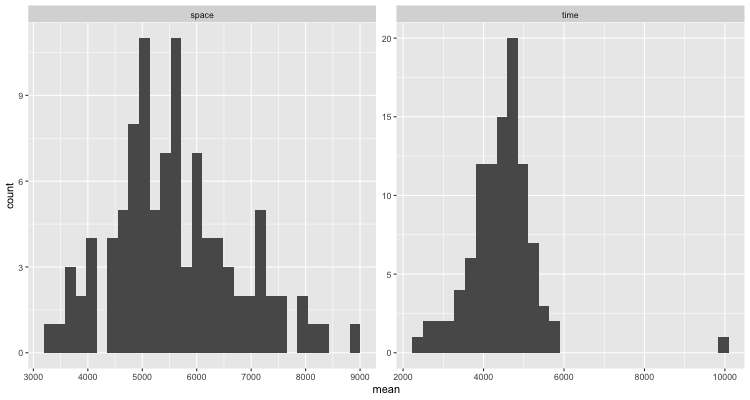

In [78]:
%%R -w 750 -h 400

permutation_errors %>%
    ggplot() +
    geom_histogram(aes(x = mean)) +
    facet_wrap(.~stat, scales = "free")

In [115]:
%%R

permutation_errors %>%
    group_by(stat) %>%
    summarize(mean_error = mean(mean),
              median_error = median(mean),
              sd_error     = sd(mean)/sqrt(n()))


# A tibble: 2 × 4
  stat  mean_error median_error sd_error
  <chr>      <dbl>        <dbl>    <dbl>
1 space      5616.        5520.    113. 
2 time       4441.        4500.     88.2


#### Mean

In [80]:
%%R

metadata_maxim_error %>%
    select(true_lat, true_lon, true_tim) %>%
    mutate(mean_lat = mean(true_lat), mean_lon = mean(true_lon), mean_tim = mean(true_tim)) %>%
    transmute(space = haversine(true_lat, true_lon, mean_lat, mean_lon),
                             time  = sqrt((mean_tim-true_tim)^2)) %>%
    gather("stat", "value", 1:2) -> mean_errors

mean_errors %>%
    head()

   stat    value
1 space 7878.636
2 space 7883.199
3 space 7864.273
4 space  439.985
5 space  373.195
6 space 1769.447


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


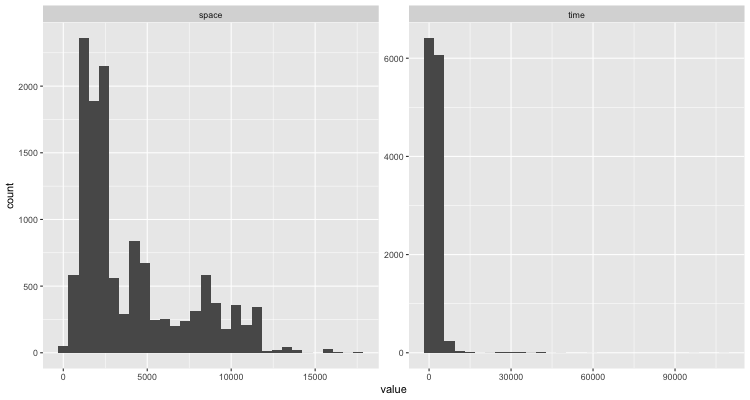

In [81]:
%%R -w 750 -h 400

mean_errors %>%
    ggplot() +
    geom_histogram(aes(x = value)) +
    facet_wrap(.~stat, scales = "free")

In [114]:
%%R

mean_errors %>%
    group_by(stat) %>%
    summarize(mean_error = mean(value),
              median_error = median(value),
              se_error = sd(value)/sqrt(n()))

# A tibble: 2 × 4
  stat  mean_error median_error se_error
  <chr>      <dbl>        <dbl>    <dbl>
1 space      4022.        2535.     29.0
2 time       2084.        1863.     23.7


#### sNNt errors

For each experiment, there is a `pred.txt` file which contains all necessary information to visualize results:

In [83]:
%%R

read.table("../../sandbox/AADR/2/pred_1_0_300000000_100000000.txt", header = T) %>%
#read.table("../../sandbox/AADR/4/pred_1_0_250000000_10000000.txt", header = T) %>%
    head()

   sim exp     nam typ cro sta       end gro    ind idx   snp      run true_lat
1 AADR   2 general  gt   1   0 100000000   0 I20444 121 40846 15.44674 40.29221
2 AADR   2 general  gt   1   0 100000000   0 I19167 175 40846 15.44674 16.49740
3 AADR   2 general  gt   1   0 100000000   0 I16425 268 40846 15.44674 49.49715
4 AADR   2 general  gt   1   0 100000000   0     BS 313 40846 15.44674 36.50000
5 AADR   2 general  gt   1   0 100000000   0 I15742 398 40846 15.44674 43.53079
6 AADR   2 general  gt   1   0 100000000   0 I26741 399 40846 15.44674 45.55101
    true_lon pred_lat   pred_lon diff_space true_tim pred_tim  diff_time
1  45.130679 51.55471   7.085716  3153.5457     2622 2463.903   158.0972
2 -88.904960 41.95430  39.007408 11606.1840     4891 4432.179   458.8208
3  -2.506461 46.26196   3.915959   598.6690     4929 2493.321  2435.6790
4 117.900000 46.75354 120.432007  1159.2284     9125 6071.009  3053.9912
5  16.260044 47.67028  13.733919   500.4175     1232 2434.110 -1202.1096
6 

In [84]:
%%bash

ls ../../sandbox/AADR/4/pred_1_0*

../../sandbox/AADR/4/pred_1_0_1000000000_1000000000.txt
../../sandbox/AADR/4/pred_1_0_250000000_10000000.txt


In [85]:
%%R -w 1000 -h 1250

read.table("../../sandbox/AADR/2/pred_1_0_300000000_100000000.txt", header = T) %>%
#read.table("../../sandbox/AADR/4/pred_1_0_1000000000_1000000000.txt", header = T) %>%
    select(-c(diff_time, diff_space)) %>%
    gather("stat", "value", c(true_lat, true_lon, pred_lat, pred_lon, true_tim,  pred_tim)) %>% 
    separate(stat, c("truepred", "stat"), sep = "_") %>%
    left_join(read.csv("../../files/AADR_filtered_metadata.txt", header = T, sep = "\t") %>%
                select(ind = indivi, master, datmet, datmea, locate, countr, latitu, longit, warnin, timind, sntind), by = c("ind")) %>% 
    mutate(truepred = factor(truepred, levels = c("true", "pred"))) -> df
    
df %>%
    head()

   sim exp     nam typ cro sta       end gro    ind idx   snp      run truepred
1 AADR   2 general  gt   1   0 100000000   0 I20444 121 40846 15.44674     true
2 AADR   2 general  gt   1   0 100000000   0 I19167 175 40846 15.44674     true
3 AADR   2 general  gt   1   0 100000000   0 I16425 268 40846 15.44674     true
4 AADR   2 general  gt   1   0 100000000   0     BS 313 40846 15.44674     true
5 AADR   2 general  gt   1   0 100000000   0 I15742 398 40846 15.44674     true
6 AADR   2 general  gt   1   0 100000000   0 I26741 399 40846 15.44674     true
  stat    value master datmet datmea
1  lat 40.29221 I20444 Direct   2622
2  lat 16.49740 I19167 Direct   4891
3  lat 49.49715 I16425 Direct   4929
4  lat 36.50000     BS Direct   9125
5  lat 43.53079 I15742 Direct   1232
6  lat 45.55101 I26741 Direct   6585
                                          locate           countr    latitu
1                                       Sarukhan          Armenia  40.29221
2                            

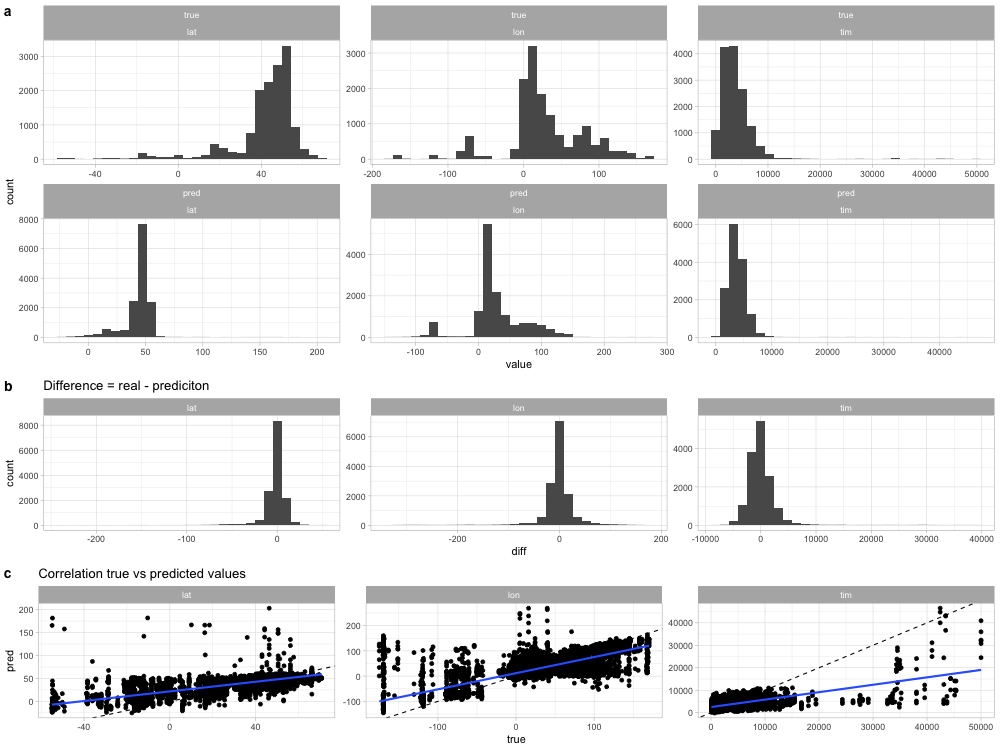

In [86]:
%%R -w 1000 -h 750

plot_grid(
    df %>%        
        ggplot() +
        geom_histogram(aes(x = value), bins = 30) + 
        facet_wrap(truepred~stat, scales = "free") +
        theme_light(),
    df %>%
        spread(truepred, value) %>%
        mutate(diff = true - pred) %>%
        ggplot() +
        geom_histogram(aes(x = diff), bins = 30) + 
        facet_wrap(.~stat, scales = "free") +
        theme_light() +
        ggtitle("Difference = real - prediciton"),
    df %>%
        spread(truepred, value) %>%
        ggplot() +
        geom_point(aes(x = true, y = pred)) +
        geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
        geom_smooth(method = "lm", formula = 'y ~ x', aes(x = true, y = pred)) +
        facet_wrap(.~stat, scales = "free") +
        theme_light() +
        ggtitle("Correlation true vs predicted values"),
    
    ncol = 1, labels = "auto", rel_heights = c(2, 1, 1)) -> plot

plot


In [87]:
%%R

df %>% 
    group_by(stat) %>%
    spread(truepred, value) %>%
    summarize(mean_pred = mean(pred), mean_true = mean(true), mean_diff = mean(true-pred), sqrtdiff = mean(sqrt((true-pred)^2))) %>%
    as.data.frame() %>%
    print()

  stat  mean_pred  mean_true mean_diff   sqrtdiff
1  lat   43.44766   41.19848 -2.249177    6.78954
2  lon   28.73331   26.82792 -1.905383   17.82892
3  tim 3808.71667 3902.73262 94.015945 1636.22567


In [88]:
%%R

get_diff_data <- function(exp, pre, cro, sta, end, win = 0, lab = "all"){
    if(win == 0){
        file <- paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", sta, "_", end, ".txt", sep = "")
    }else{
        file <- paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", sta, "_", end, "_", win, ".txt", sep = "")
    }
    read.table(file, header = T) %>%
            mutate(extendedexp = paste(exp, cro, format(as.numeric(sta), scientific = FALSE, trim = TRUE), 
                                                 format(as.numeric(end), scientific = FALSE, trim = TRUE), lab, sep = "_")) -> df
    
    if(pre == "space"){
        df %>%
            select(-c(true_lat, true_lon, pred_lat, pred_lon)) %>%
            rename(space = diff_space) %>%
            gather("stat", "value", c(space)) -> df
    }else if(pre == "time"){
        df %>%
            select(-c(true_tim,  pred_tim)) %>%
            rename(time = diff_time) %>%
            gather("stat", "value", c(time)) -> df

    }else{
        df %>%
            select(-c(true_lat, true_lon, pred_lat, pred_lon, true_tim,  pred_tim)) %>%
            rename(time = diff_time, space = diff_space) %>%
            gather("stat", "value", c(time, space)) -> df
            
    }
     df %>%
        left_join(read.csv("../../files/AADR_filtered_metadata.txt", header = T, sep = "\t") %>%
                select(ind = indivi, master, datmet, datmea, locate, countr, latitu, longit, warnin, timind, sntind), by = c("ind")) %>%
            ######################################REMOVE MODERN INDIVIDUALS#######################################    
            filter(datmet != "Modern") %>%
            mutate(value = as.numeric(value),
                   snp   = as.numeric(snp),
                   run   = as.numeric(run),
                   cro   = as.character(cro),
                   sta   = as.numeric(sta),
                   end   = as.numeric(end)) %>%
            ungroup()
                   
}

    

get_diff_data(2, "sNNt", 1,  "0", "300000000", "100000000") %>%
    head()

   sim exp     nam typ cro sta   end gro    ind idx   snp      run
1 AADR   2 general  gt   1   0 1e+08   0 I20444 121 40846 15.44674
2 AADR   2 general  gt   1   0 1e+08   0 I19167 175 40846 15.44674
3 AADR   2 general  gt   1   0 1e+08   0 I16425 268 40846 15.44674
4 AADR   2 general  gt   1   0 1e+08   0     BS 313 40846 15.44674
5 AADR   2 general  gt   1   0 1e+08   0 I15742 398 40846 15.44674
6 AADR   2 general  gt   1   0 1e+08   0 I26741 399 40846 15.44674
          extendedexp stat      value master datmet datmea
1 2_1_0_100000000_all time   158.0972 I20444 Direct   2622
2 2_1_0_100000000_all time   458.8208 I19167 Direct   4891
3 2_1_0_100000000_all time  2435.6790 I16425 Direct   4929
4 2_1_0_100000000_all time  3053.9912     BS Direct   9125
5 2_1_0_100000000_all time -1202.1096 I15742 Direct   1232
6 2_1_0_100000000_all time  1098.5635 I26741 Direct   6585
                                          locate           countr    latitu
1                                       Sa

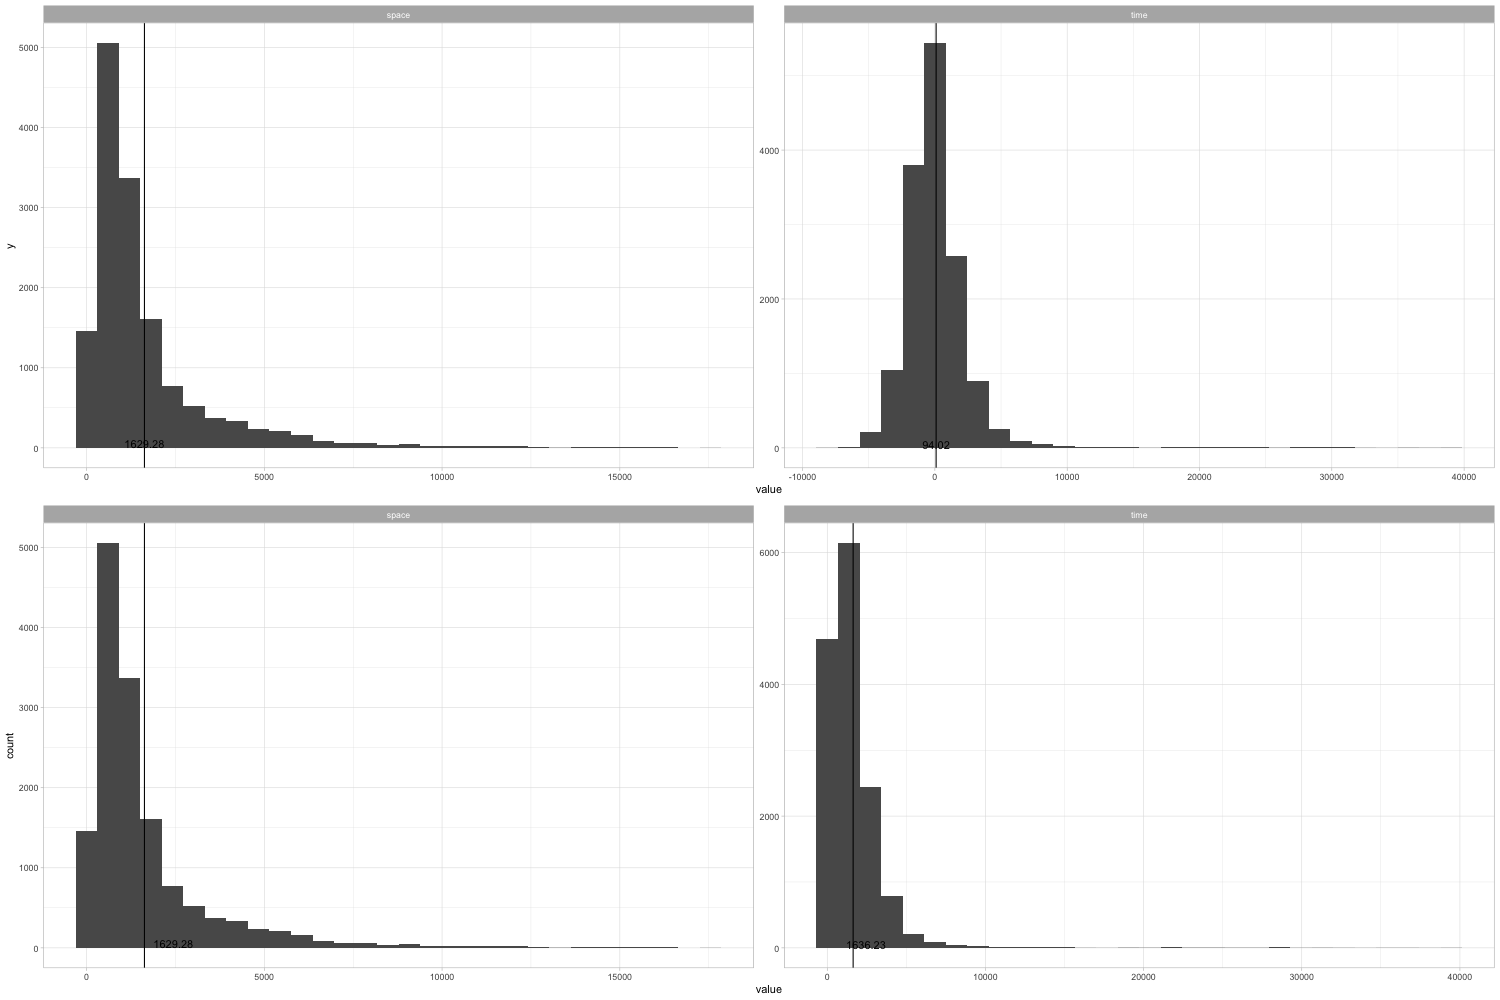

In [89]:
%%R -w 1500 -h 1000

exp = "2"
cro = "1"
sta = "0"
end = "300000000"
win = "100000000"
pre = "sNNt"


plot_grid(
    get_diff_data(exp, pre, cro, sta, end, win) %>%
        ggplot() +
        geom_histogram(aes(x = value), bins = 30) +
        geom_vline(data = . %>% group_by(stat) %>% summarize(mean = mean(value)), aes(xintercept = mean)) +
        geom_text(data = . %>% group_by(stat) %>% summarize(mean = mean(value)), aes(x = mean, y = 50, label = round(mean, 2))) +   
        facet_wrap(.~stat, scales = "free") +
        theme_light(),
    
    get_diff_data(exp, pre, cro, sta, end, win) %>%
        mutate(value = sqrt(value^2)) %>%
        ggplot() +
        geom_histogram(aes(x = value), bins = 30) +
        geom_vline(data = . %>% group_by(stat) %>% summarize(mean = mean(value)), aes(xintercept = mean)) +
        geom_text(data = . %>% group_by(stat) %>% summarize(mean = mean(value)), aes(x = mean+(mean*0.5), y = 50, label = round(mean, 2))) +
        ylab("count") +
        facet_wrap(.~stat, scales = "free") +
        theme_light(),
    
    nrow = 2) -> plot

plot

In [90]:
%%R


error_spaceNNtime_all_scenarios <- function(){
    read.csv("../../files/experiments_AADR.csv", sep = ";") -> experiments
    
    all_scenarios = data.frame()
    
    #for(i in 1:(experiments %>% nrow())-1){
    for(i in c(1:36)){
        print(i)
        #print(experiments[i,])
        #sim = experiments %>% pull(sim) %>% .[i]
        exp = experiments %>% pull(exp) %>% .[i]
        pre = experiments %>% pull(pre) %>% .[i]
        cro = experiments %>% pull(cro) %>% .[i]
        sta = experiments %>% pull(sta) %>% .[i]
        sta = as.numeric(sta)*1e6
        end = experiments %>% pull(end) %>% .[i]
        end = as.numeric(end)*1e6
        win = experiments %>% pull(win) %>% .[i]
        win = as.numeric(win)*1e6
        pre = experiments %>% pull(pre) %>% .[i]
        
        c = format(sta, scientific = FALSE, trim = TRUE)
        e = format(end, scientific = FALSE, trim = TRUE)
        w = format(win, scientific = FALSE, trim = TRUE)
        
        
        
        if(file.exists(paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", c, "_", e, "_", w, ".txt", sep = ""))){
            all_scenarios = rbind(all_scenarios, 
                                  get_diff_data(exp, pre, cro, c, e, w) %>%
                                              mutate(value = abs(value)) %>%
                                              group_by(exp, cro, sta, end, extendedexp, nam, typ, stat) %>%
                                              summarize(mean = mean(value),
                                                        se   = sd(value)/sqrt(n()),
                                                        n    = n(),
                                                        snp  = mean(snp),
                                                        run  = mean(run)) %>%
                                              mutate(exp = factor(exp))
                                         )
        }else{
            for(s in seq(sta, end-win, win)){             
                z = format(s, scientific = FALSE, trim = TRUE)
                y = format(s+win, scientific = FALSE, trim = TRUE)
                if(file.exists(paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", z, "_", y, ".txt", sep = ""))){
                    all_scenarios = rbind(all_scenarios, 
                                          get_diff_data(exp, pre, cro, z, y) %>%
                                              mutate(value = abs(value)) %>%
                                              group_by(exp, cro, sta, end, extendedexp, nam, typ, stat) %>%
                                              summarize(mean = mean(value),
                                                        se   = sd(value)/sqrt(n()),
                                                        n    = n(),
                                                        snp  = mean(snp),
                                                        run  = mean(run)) %>%
                                              mutate(exp = factor(exp))
                                         )
                }else{
                    print(paste("the file ", paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", z, "_", y, ".txt", sep = ""), " nor ", paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", z, "_", e, "_", w, ".txt", sep = ""), " does not exist!", sep = ""))
                }
            }

        
        }
        
    }
    all_scenarios %>% mutate(nn = 1)
}

all_scenarios <- error_spaceNNtime_all_scenarios()
head(all_scenarios)

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] "the file ../../sandbox/AADR/11/pred_1_0_1000000000.txt nor ../../sandbox/AADR/11/pred_1_0_1000000000_1000000000.txt does not exist!"
[1] 21
[1] "the file ../../sandbox/AADR/11/pred_2_0_1000000000.txt nor ../../sandbox/AADR/11/pred_2_0_1000000000_1000000000.txt does not exist!"
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
# A tibble: 6 × 14
# Groups:   exp, cro, sta, end, extendedexp, nam, typ [3]
  exp   cro      sta   end extendedexp nam   typ   stat   mean    se     n   snp
  <fct> <chr>  <dbl> <dbl> <chr>       <chr> <chr> <chr> <dbl> <dbl> <int> <dbl>
1 1     1        0     1e8 1_1_0_1000… loss  gt    space 1906.  29.3  4847 40846
2 1     1        0     1e8 1_1_0_1000… loss  gt    time  1564.  32.5  4847 40846
3 2     1        0     1e8 2_1_0_1000… gene… gt    space 1495.  24.8  4847 40846

In [91]:
%%R

get_all_data <- function(exp, pre, cro, sta, end, win=0){
    if(win == 0){
        file <- paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", sta, "_", end, ".txt", sep = "")
    }else{
        file <- paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", sta, "_", end, "_", win, ".txt", sep = "")
    }
    
    read.table(file, header = T) %>%
        #mutate(cro = cro, sta = sta, end = end) %>%
        mutate(extendedexp = paste(exp, cro, format(as.numeric(sta), scientific = FALSE, trim = TRUE), 
                                             format(as.numeric(end), scientific = FALSE, trim = TRUE), 
                                             format(as.numeric(win), scientific = FALSE, trim = TRUE), sep = "_")) %>%
        left_join(read.csv("../../files/AADR_filtered_metadata.txt", header = T, sep = "\t") %>%
             select(ind = indivi, master, datmet, datmea, locate, countr, latitu, longit, warnin, timind, sntind), by = c("ind")) %>%
        ######################################REMOVE MODERN INDIVIDUALS#######################################    
        filter(datmet != "Modern") -> a
    if(pre == "space"){
        a %>%
            mutate(true_tim = 0, pred_tim = 0, diff_time = 0) -> a
    }
    if(pre == "time"){
        a %>%
            mutate(true_lat = 0, true_lon = 0, pred_lat = 0, pred_lon = 0, diff_space = 0) -> a
    }  

    a %>%             
        mutate(snp   = as.numeric(snp),
               run   = as.numeric(run),
               cro   = as.character(cro),
               sta   = as.numeric(sta),
               end   = as.numeric(end)) %>%
            ungroup()
        
}

get_all_data(2, "sNNt", "1", "0", "300000000", "100000000") %>%
    head()

   sim exp     nam typ cro sta   end gro    ind idx   snp      run true_lat
1 AADR   2 general  gt   1   0 1e+08   0 I20444 121 40846 15.44674 40.29221
2 AADR   2 general  gt   1   0 1e+08   0 I19167 175 40846 15.44674 16.49740
3 AADR   2 general  gt   1   0 1e+08   0 I16425 268 40846 15.44674 49.49715
4 AADR   2 general  gt   1   0 1e+08   0     BS 313 40846 15.44674 36.50000
5 AADR   2 general  gt   1   0 1e+08   0 I15742 398 40846 15.44674 43.53079
6 AADR   2 general  gt   1   0 1e+08   0 I26741 399 40846 15.44674 45.55101
    true_lon pred_lat   pred_lon diff_space true_tim pred_tim  diff_time
1  45.130679 51.55471   7.085716  3153.5457     2622 2463.903   158.0972
2 -88.904960 41.95430  39.007408 11606.1840     4891 4432.179   458.8208
3  -2.506461 46.26196   3.915959   598.6690     4929 2493.321  2435.6790
4 117.900000 46.75354 120.432007  1159.2284     9125 6071.009  3053.9912
5  16.260044 47.67028  13.733919   500.4175     1232 2434.110 -1202.1096
6  18.746617 45.50764  10.7792

In [92]:
%%R



get_all_data_all_scenarios <- function(){
    read.csv("../../files/experiments_AADR.csv", sep = ";") -> experiments

    all_scenarios = data.frame()
    
    #for(i in 1:(experiments %>% nrow())){
    for(i in c(1:36)){
        #for(i in c(4, 34, 35, 36, 37, 38, 39, 40)){
        print(i)
        #sim = experiments %>% pull(sim) %>% .[i]
        exp = experiments %>% pull(exp) %>% .[i]
        pre = experiments %>% pull(pre) %>% .[i]
        cro = experiments %>% pull(cro) %>% .[i]
        sta = experiments %>% pull(sta) %>% .[i]
        sta = as.numeric(sta)*1e6
        end = experiments %>% pull(end) %>% .[i]
        end = as.numeric(end)*1e6
        win = experiments %>% pull(win) %>% .[i]
        win = as.numeric(win)*1e6
        pre = experiments %>% pull(pre) %>% .[i]
        
        c = format(sta, scientific = FALSE, trim = TRUE)
        e = format(end, scientific = FALSE, trim = TRUE)
        w = format(win, scientific = FALSE, trim = TRUE)
        
        if(file.exists(paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", c, "_", e, "_", w, ".txt", sep = ""))){
            all_scenarios = rbind(all_scenarios, 
                                  get_all_data(exp, pre, cro, c, e, w) 
                                         )
        }else{
            for(s in seq(sta, end-win, win)){  
                z = format(s, scientific = FALSE, trim = TRUE)
                y = format(s+win, scientific = FALSE, trim = TRUE)
                if(file.exists(paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", z, "_", y, ".txt", sep = ""))){
                    all_scenarios = rbind(all_scenarios, 
                                          get_all_data(exp, pre, cro, z, y) 
                                         )
                }else{
                    print(paste("the file ", paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", z, "_", y, ".txt", sep = ""), " nor ", paste("../../sandbox/AADR/", exp, "/pred_", cro, "_", z, "_", e, "_", w, ".txt", sep = ""), " does not exist!", sep = ""))
                }
            }

        }
    }
    all_scenarios %>%
        mutate(true_lat = as.numeric(true_lat),
               true_lon = as.numeric(true_lon),
               pred_lat = as.numeric(pred_lat),
               pred_lon = as.numeric(pred_lon),
               diff_space = as.numeric(diff_space),
               true_tim = as.numeric(true_tim),
               pred_tim = as.numeric(pred_tim),
               diff_time = as.numeric(diff_time),
               snp   = as.numeric(snp),
               run   = as.numeric(run),
               cro   = as.character(cro),
               sta   = as.numeric(sta),
               end   = as.numeric(end),
               win   = as.numeric(win)) %>%
            ungroup()
}    
    
get_all_data_all_scenarios_df <- get_all_data_all_scenarios()
head(get_all_data_all_scenarios_df)


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] "the file ../../sandbox/AADR/11/pred_1_0_1000000000.txt nor ../../sandbox/AADR/11/pred_1_0_1000000000_1000000000.txt does not exist!"
[1] 21
[1] "the file ../../sandbox/AADR/11/pred_2_0_1000000000.txt nor ../../sandbox/AADR/11/pred_2_0_1000000000_1000000000.txt does not exist!"
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
   sim exp  nam typ cro sta   end gro    ind idx   snp      run true_lat
1 AADR   1 loss  gt   1   0 1e+08   0 I20444 121 40846 9.460483 40.29221
2 AADR   1 loss  gt   1   0 1e+08   0 I19167 175 40846 9.460483 16.49740
3 AADR   1 loss  gt   1   0 1e+08   0 I16425 268 40846 9.460483 49.49715
4 AADR   1 loss  gt   1   0 1e+08   0     BS 313 40846 9.460483 36.50000
5 AADR   1 loss  gt   1   0 1e+08   0 I15742 398 40846 9.460483 43.53079
6 AADR   1 loss  gt   1   0 1e+08   0 I2674

In [93]:
%%R

get_all_data_all_scenarios_df %>%
    count(pred_lat < -90, pred_lat > 90, pred_lon < -180, pred_lon > 180)

  pred_lat < -90 pred_lat > 90 pred_lon < -180 pred_lon > 180      n
1          FALSE         FALSE           FALSE          FALSE 457234
2          FALSE         FALSE           FALSE           TRUE      9
3          FALSE          TRUE           FALSE          FALSE   1563
4          FALSE          TRUE           FALSE           TRUE    274
5           TRUE         FALSE           FALSE          FALSE     32
6           TRUE         FALSE           FALSE           TRUE      5
7           TRUE         FALSE            TRUE          FALSE    114


In [94]:
%%R

error_spaceNNtime_mean_windows_per_ind <- function(df, per_chromosome = TRUE){
    if(!per_chromosome){
        df %>% mutate(cro = "all") -> df
    }
    df %>%
        mutate(win = format(end-sta, scientific = FALSE, trim = TRUE))  %>%
        mutate(extendedexp = paste(exp, cro, format(as.numeric(sta), scientific = FALSE, trim = TRUE), 
                                             format(as.numeric(end), scientific = FALSE, trim = TRUE), 
                                             format(as.numeric(win), scientific = FALSE, trim = TRUE), sep = "_")) %>%
        group_by(sim, exp, ind, cro, win) %>%
        summarize(sta = min(sta),
                  end = max(end),
                  nn  = n(),
                  run = mean(run),
                  true_lat = mean(true_lat),
                  true_lon = mean(true_lon),
                  true_tim = mean(true_tim),
                  mean_pred_lat = mean(pred_lat),
                  mean_pred_lon = mean(pred_lon),
                  mean_pred_tim = mean(pred_tim),
                  meaw_pred_lat = weighted.mean(pred_lat, snp),
                  meaw_pred_lon = weighted.mean(pred_lon, snp),
                  meaw_pred_tim = weighted.mean(pred_tim, snp),
                  median_pred_lat = median(pred_lat),
                  median_pred_lon = median(pred_lon),
                  median_pred_tim = median(pred_tim),
                  kernel_pred_lat = maxkernel(pred_lat),
                  kernel_pred_lon = maxkernel(pred_lon),
                  kernel_pred_tim = maxkernel(pred_tim),
                  kernew_pred_lat = maxkernel(pred_lat, snp),
                  kernew_pred_lon = maxkernel(pred_lon, snp),
                  kernew_pred_tim = maxkernel(pred_tim, snp),
                  snp = mean(snp)) %>%
       ungroup() %>%
       mutate(mean_space   = haversine(true_lat, true_lon, mean_pred_lat, mean_pred_lon),
              mean_time    = sqrt((mean_pred_tim-true_tim)^2),
              meaw_space   = haversine(true_lat, true_lon, meaw_pred_lat, meaw_pred_lon),
              meaw_time    = sqrt((meaw_pred_tim-true_tim)^2),
              median_space = haversine(true_lat, true_lon, median_pred_lat, median_pred_lon),
              median_time  = sqrt((median_pred_tim-true_tim)^2),
              kernel_space = haversine(true_lat, true_lon, kernel_pred_lat, kernel_pred_lon),
              kernel_time  = sqrt((kernel_pred_tim-true_tim)^2),
              kernew_space = haversine(true_lat, true_lon, kernew_pred_lat, kernew_pred_lon),
              kernew_time  = sqrt((kernew_pred_tim-true_tim)^2),
              extendedexp = paste(exp, cro, format(as.numeric(sta), scientific = FALSE, trim = TRUE), 
                                            format(as.numeric(end), scientific = FALSE, trim = TRUE), 
                                            format(as.numeric(win), scientific = FALSE, trim = TRUE), sep = "_"),
              nam = "average",
              typ = "gt") %>% 
       as.data.frame()
        
}

In [106]:
%%R

error_spaceNNtime_mean_windows_per_experiment <- function(df){
    df %>%
       select(-c(sim, true_lat, true_lon, mean_pred_lat, mean_pred_lon, meaw_pred_lat, meaw_pred_lon, median_pred_lat, median_pred_lon, kernel_pred_lat, kernel_pred_lon, kernew_pred_lat, kernew_pred_lon, true_tim, mean_pred_tim, meaw_pred_tim, median_pred_tim, kernel_pred_tim, kernew_pred_tim)) %>%
       gather("stat", "diff", mean_space, mean_time, meaw_space, meaw_time, median_space, median_time, kernel_space, kernel_time, kernew_space, kernew_time) %>% 
       separate(stat, into = c("aver", "stat"), sep = "_") %>%
       mutate(extendedexp = paste(extendedexp, aver, sep = "_")) %>%
       group_by(exp, cro, sta, end, extendedexp, nam, typ, stat) %>%
       filter(nn == max(nn)) %>% 
       summarize(mean = mean(diff), se = sd(diff)/sqrt(n()), n = n(), snp = mean(snp), run = mean(run), nn = mean(nn)) %>% 
       ungroup() 
}

In [108]:
%%R

error_spaceNNtime_mean_windows_per_ind(get_all_data_all_scenarios_df) -> error_spaceNNtime_mean_windows_per_ind_per_chro_df
error_spaceNNtime_mean_windows_per_experiment(error_spaceNNtime_mean_windows_per_ind_per_chro_df) -> error_spaceNNtime_mean_windows_per_chro_df

error_spaceNNtime_mean_windows_per_chro_df %>% head()

# A tibble: 6 × 14
  exp   cro     sta    end extendedexp nam   typ   stat   mean    se     n   snp
  <chr> <chr> <dbl>  <dbl> <chr>       <chr> <chr> <chr> <dbl> <dbl> <int> <dbl>
1 1     1         0    1e8 1_1_0_1000… aver… gt    space 1906.  29.3  4847 40846
2 1     1         0    1e8 1_1_0_1000… aver… gt    time  1564.  32.5  4847 40846
3 1     1         0    1e8 1_1_0_1000… aver… gt    space 1906.  29.3  4847 40846
4 1     1         0    1e8 1_1_0_1000… aver… gt    time  1564.  32.5  4847 40846
5 1     1         0    1e8 1_1_0_1000… aver… gt    space 1906.  29.3  4847 40846
6 1     1         0    1e8 1_1_0_1000… aver… gt    time  1564.  32.5  4847 40846
# ℹ 2 more variables: run <dbl>, nn <dbl>


In [109]:
%%R

error_spaceNNtime_mean_windows_per_ind(get_all_data_all_scenarios_df, FALSE) -> error_spaceNNtime_mean_windows_per_ind_df
error_spaceNNtime_mean_windows_per_experiment(error_spaceNNtime_mean_windows_per_ind_df) -> error_spaceNNtime_mean_windows_df

error_spaceNNtime_mean_windows_df %>% head()

# A tibble: 6 × 14
  exp   cro     sta    end extendedexp nam   typ   stat   mean    se     n   snp
  <chr> <chr> <dbl>  <dbl> <chr>       <chr> <chr> <chr> <dbl> <dbl> <int> <dbl>
1 1     all       0    1e8 1_all_0_10… aver… gt    space 1906.  29.3  4847 40846
2 1     all       0    1e8 1_all_0_10… aver… gt    time  1564.  32.5  4847 40846
3 1     all       0    1e8 1_all_0_10… aver… gt    space 1906.  29.3  4847 40846
4 1     all       0    1e8 1_all_0_10… aver… gt    time  1564.  32.5  4847 40846
5 1     all       0    1e8 1_all_0_10… aver… gt    space 1906.  29.3  4847 40846
6 1     all       0    1e8 1_all_0_10… aver… gt    time  1564.  32.5  4847 40846
# ℹ 2 more variables: run <dbl>, nn <dbl>


In [132]:
%%R

plot_errors <- function(all_scenarios_all, exp_to_plot, labels, limits, title, xlab, ylab, ylimspace = c("None", "None"), ylimtime = c("None", "None"), nolegend = TRUE, show_perm_mean_err = FALSE){

    df_mean_error = data.frame(stat   = c("space", "time", "space", "time", "space", "time", "space", "time"),
                           err    = c( "mean", "mean",  "mean", "mean",  "perm", "perm",  "perm", "perm"),
                           sumari = c( "mean", "mean",  "medi", "medi",  "mean", "mean",  "medi", "medi"),
                           value  = c(   4022,   2084,    2535,   1863,    5616,   4441,    5520,   4500))

    
    all_scenarios_all %>% 
        filter(extendedexp %in% exp_to_plot,
               stat == "space") %>%
        ggplot() +
        geom_errorbar(aes(x = extendedexp, ymin = mean-se, ymax = mean+se), alpha = 0.5, width = 0.2) +
        geom_line(aes(x = extendedexp, y = mean, group = 1), alpha = 0.5, linetype = "dashed") +
        geom_point(aes(x = extendedexp, y = mean), size = 3) +
        geom_text(aes(x = extendedexp, y = mean*1.10, label = n), size = 3) +
        geom_text(aes(x = extendedexp, y = mean*0.90, label = nn), size = 3) +
        geom_text(aes(x = extendedexp, y = mean*0.80, label = round(run, 2)), size = 3) +
        geom_text(aes(x = extendedexp, y = mean*1.20, label = round(snp, 2)), size = 3) +
        labs(x = xlab, y = ylab) +
        scale_x_discrete(labels = labels, limits = limits) +
        facet_wrap(stat~., nrow = 2, scales = "free") +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
        theme_light() -> plot1
    
    if(ylimspace[1] != "None"){
        plot1 + coord_cartesian(ylim = ylimspace) -> plot1
    }
    if(nolegend){
        plot1 + theme(legend.position = 'none', axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) -> plot1
    }
    if(show_perm_mean_err){
        plot1 + geom_hline(data = df_mean_error %>% filter(stat == "space"), aes(yintercept = value, color = err, linetype = sumari)) -> plot1
    }

    all_scenarios_all %>% 
        filter(extendedexp %in% exp_to_plot,
               stat == "time") %>%
        ggplot() +
        geom_errorbar(aes(x = extendedexp, ymin = mean-se, ymax = mean+se), alpha = 0.5, width = 0.2) +
        geom_line(aes(x = extendedexp, y = mean, group = 1), alpha = 0.5, linetype = "dashed") +
        geom_point(aes(x = extendedexp, y = mean), size = 3) +
        geom_text(aes(x = extendedexp, y = mean*1.10, label = n), size = 3) +
        geom_text(aes(x = extendedexp, y = mean*0.90, label = nn), size = 3) +
        geom_text(aes(x = extendedexp, y = mean*0.80, label = round(run, 2)), size = 3) +
        geom_text(aes(x = extendedexp, y = mean*1.20, label = round(snp, 2)), size = 3) +
        labs(x = xlab, y = ylab) +
        scale_x_discrete(labels=labels, limits = limits) +
        facet_wrap(stat~., nrow = 2, scales = "free") +
        theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
        theme_light() -> plot2
    
    if(ylimtime[1] != "None"){
        plot2 + coord_cartesian(ylim = ylimtime) -> plot2
    }
    if(nolegend){
        plot2 + theme(legend.position = 'none', axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) -> plot2
    }
    if(show_perm_mean_err){
        plot2 + geom_hline(data = df_mean_error %>% filter(stat == "time"), aes(yintercept = value, color = err, linetype = sumari)) -> plot2
    }
    title <- ggdraw() + draw_label(title)
    
    plot_grid(title, plot1, plot2, ncol = 1, rel_heights=c(0.1, 1, 1))

}

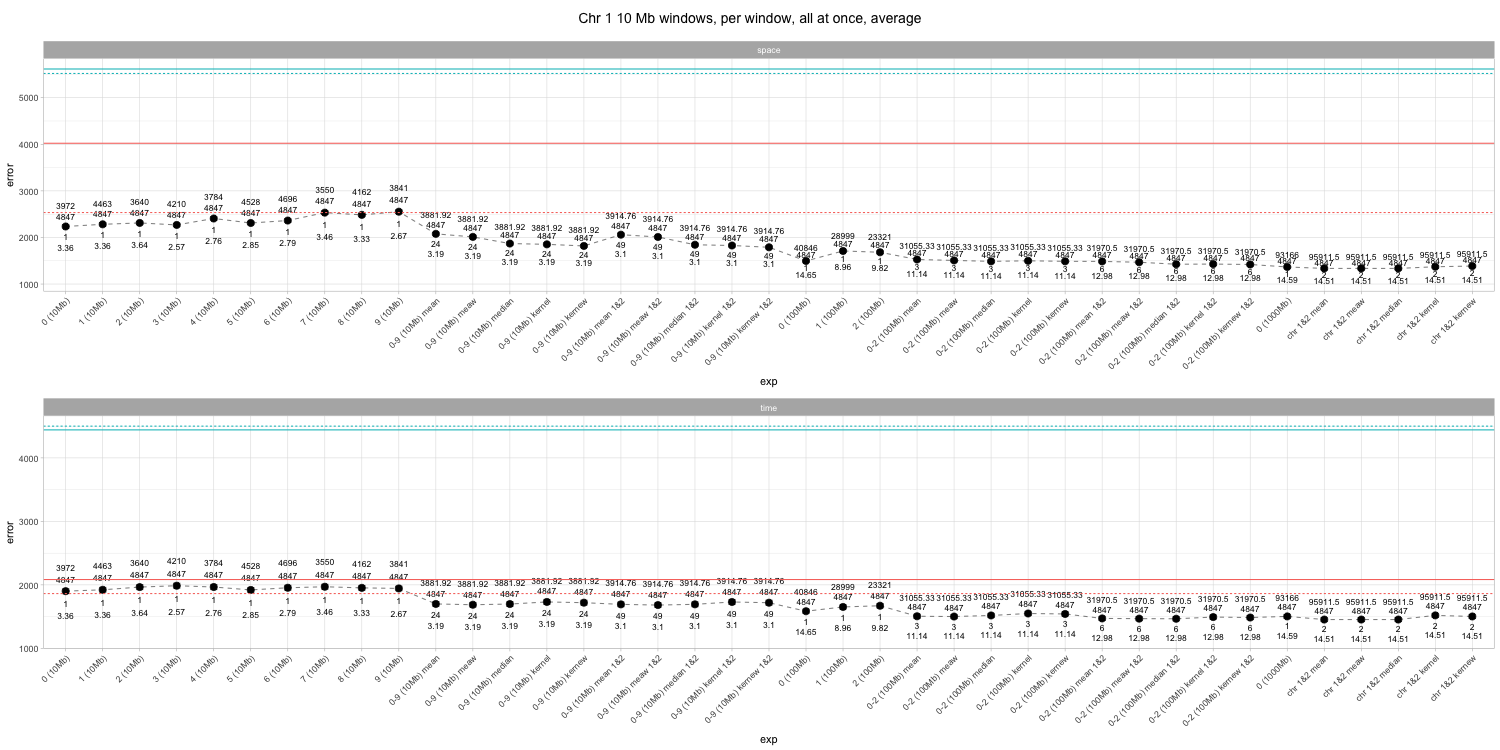

In [225]:
%%R -w 1500 -h 750

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("4_1_0_10000000_all",              "4_1_10000000_20000000_all",              "4_1_20000000_30000000_all",              "4_1_30000000_40000000_all",              "4_1_40000000_50000000_all",              "4_1_50000000_60000000_all",              "4_1_60000000_70000000_all",              "4_1_70000000_80000000_all",              "4_1_80000000_90000000_all",              "4_1_90000000_100000000_all",               "4_1_0_250000000_10000000_mean",                     "4_1_0_250000000_10000000_meaw",                     "4_1_0_250000000_10000000_median",                       "4_1_0_250000000_10000000_kernel",                       "4_1_0_250000000_10000000_kernew",                       "4_all_0_250000000_10000000_mean",                         "4_all_0_250000000_10000000_meaw",                         "4_all_0_250000000_10000000_median",                           "4_all_0_250000000_10000000_kernel",                           "4_all_0_250000000_10000000_kernew",                           "2_1_0_100000000_all",               "2_1_100000000_200000000_all",               "2_1_200000000_300000000_all",               "2_1_0_300000000_100000000_mean",                      "2_1_0_300000000_100000000_meaw",                      "2_1_0_300000000_100000000_median",                        "2_1_0_300000000_100000000_kernel",                        "2_1_0_300000000_100000000_kernew",                        "2_all_0_300000000_100000000_mean",                          "2_all_0_300000000_100000000_meaw",                          "2_all_0_300000000_100000000_median",                            "2_all_0_300000000_100000000_kernel",                            "2_all_0_300000000_100000000_kernew",                            "4_1_0_1000000000_all"               , "4_all_0_1000000000_1000000000_mean"                 , "4_all_0_1000000000_1000000000_meaw"                 , "4_all_0_1000000000_1000000000_median"                   , "4_all_0_1000000000_1000000000_kernel"                   , "4_all_0_1000000000_1000000000_kernew"                   ), 
            labels            = c("4_1_0_10000000_all" = "0 (10Mb)", "4_1_10000000_20000000_all" = "1 (10Mb)", "4_1_20000000_30000000_all" = "2 (10Mb)", "4_1_30000000_40000000_all" = "3 (10Mb)", "4_1_40000000_50000000_all" = "4 (10Mb)", "4_1_50000000_60000000_all" = "5 (10Mb)", "4_1_60000000_70000000_all" = "6 (10Mb)", "4_1_70000000_80000000_all" = "7 (10Mb)", "4_1_80000000_90000000_all" = "8 (10Mb)", "4_1_90000000_100000000_all" = "9 (10Mb)",  "4_1_0_250000000_10000000_mean" = "0-9 (10Mb) mean", "4_1_0_250000000_10000000_meaw" = "0-9 (10Mb) meaw", "4_1_0_250000000_10000000_median" = "0-9 (10Mb) median", "4_1_0_250000000_10000000_kernel" = "0-9 (10Mb) kernel", "4_1_0_250000000_10000000_kernew" = "0-9 (10Mb) kernew", "4_all_0_250000000_10000000_mean" = "0-9 (10Mb) mean 1&2", "4_all_0_250000000_10000000_meaw" = "0-9 (10Mb) meaw 1&2", "4_all_0_250000000_10000000_median" = "0-9 (10Mb) median 1&2", "4_all_0_250000000_10000000_kernel" = "0-9 (10Mb) kernel 1&2", "4_all_0_250000000_10000000_kernew" = "0-9 (10Mb) kernew 1&2", "2_1_0_100000000_all" = "0 (100Mb)", "2_1_100000000_200000000_all" = "1 (100Mb)", "2_1_200000000_300000000_all" = "2 (100Mb)", "2_1_0_300000000_100000000_mean" = "0-2 (100Mb) mean", "2_1_0_300000000_100000000_meaw" = "0-2 (100Mb) meaw", "2_1_0_300000000_100000000_median" = "0-2 (100Mb) median", "2_1_0_300000000_100000000_kernel" = "0-2 (100Mb) kernel", "2_1_0_300000000_100000000_kernew" = "0-2 (100Mb) kernew", "2_all_0_300000000_100000000_mean" = "0-2 (100Mb) mean 1&2", "2_all_0_300000000_100000000_meaw" = "0-2 (100Mb) meaw 1&2", "2_all_0_300000000_100000000_median" = "0-2 (100Mb) median 1&2", "2_all_0_300000000_100000000_kernel" = "0-2 (100Mb) kernel 1&2", "2_all_0_300000000_100000000_kernew" = "0-2 (100Mb) kernew 1&2", "4_1_0_1000000000_all" = "0 (1000Mb)", "4_all_0_1000000000_1000000000_mean" = "chr 1&2 mean", "4_all_0_1000000000_1000000000_meaw" = "chr 1&2 meaw", "4_all_0_1000000000_1000000000_median" = "chr 1&2 median", "4_all_0_1000000000_1000000000_kernel" = "chr 1&2 kernel", "4_all_0_1000000000_1000000000_kernew" = "chr 1&2 kernew"), 
            limits            = c("4_1_0_10000000_all",              "4_1_10000000_20000000_all",              "4_1_20000000_30000000_all",              "4_1_30000000_40000000_all",              "4_1_40000000_50000000_all",              "4_1_50000000_60000000_all",              "4_1_60000000_70000000_all",              "4_1_70000000_80000000_all",              "4_1_80000000_90000000_all",              "4_1_90000000_100000000_all",               "4_1_0_250000000_10000000_mean",                     "4_1_0_250000000_10000000_meaw",                     "4_1_0_250000000_10000000_median",                       "4_1_0_250000000_10000000_kernel",                       "4_1_0_250000000_10000000_kernew",                       "4_all_0_250000000_10000000_mean",                         "4_all_0_250000000_10000000_meaw",                         "4_all_0_250000000_10000000_median",                           "4_all_0_250000000_10000000_kernel",                           "4_all_0_250000000_10000000_kernew",                           "2_1_0_100000000_all",               "2_1_100000000_200000000_all",               "2_1_200000000_300000000_all",               "2_1_0_300000000_100000000_mean",                      "2_1_0_300000000_100000000_meaw",                      "2_1_0_300000000_100000000_median",                        "2_1_0_300000000_100000000_kernel",                        "2_1_0_300000000_100000000_kernew",                        "2_all_0_300000000_100000000_mean",                          "2_all_0_300000000_100000000_meaw",                          "2_all_0_300000000_100000000_median",                            "2_all_0_300000000_100000000_kernel",                            "2_all_0_300000000_100000000_kernew",                            "4_1_0_1000000000_all"               , "4_all_0_1000000000_1000000000_mean"                 , "4_all_0_1000000000_1000000000_meaw"                 , "4_all_0_1000000000_1000000000_median"                   , "4_all_0_1000000000_1000000000_kernel"                   , "4_all_0_1000000000_1000000000_kernew"                   ),  
            title             = "Chr 1 10 Mb windows, per window, all at once, average", 
            xlab              = "exp", 
            ylab              = "error",
            show_perm_mean_err = TRUE) 
    

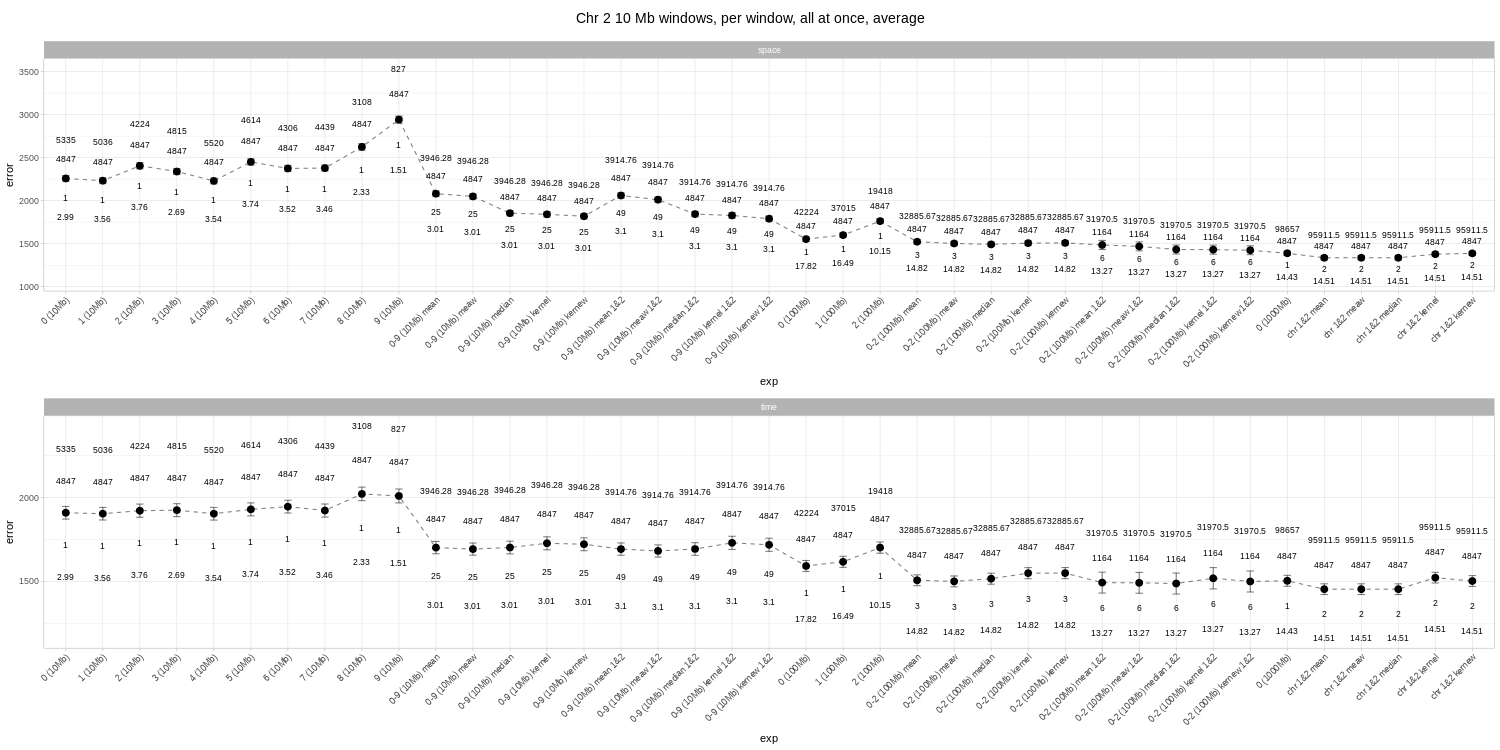

In [42]:
%%R -w 1500 -h 750

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("4_2_0_10000000_all",              "4_2_10000000_20000000_all",              "4_2_20000000_30000000_all",              "4_2_30000000_40000000_all",              "4_2_40000000_50000000_all",              "4_2_50000000_60000000_all",              "4_2_60000000_70000000_all",              "4_2_70000000_80000000_all",              "4_2_80000000_90000000_all",              "4_2_90000000_100000000_all",               "4_2_0_250000000_10000000_mean",                     "4_2_0_250000000_10000000_meaw",                     "4_2_0_250000000_10000000_median",                       "4_2_0_250000000_10000000_kernel",                       "4_2_0_250000000_10000000_kernew",                       "4_all_0_250000000_10000000_mean",                         "4_all_0_250000000_10000000_meaw",                         "4_all_0_250000000_10000000_median",                           "4_all_0_250000000_10000000_kernel",                           "4_all_0_250000000_10000000_kernew",                           "2_2_0_100000000_all",               "2_2_100000000_200000000_all",               "2_2_200000000_300000000_all",               "2_2_0_300000000_100000000_mean",                      "2_2_0_300000000_100000000_meaw",                      "2_2_0_300000000_100000000_median",                        "2_2_0_300000000_100000000_kernel",                        "2_2_0_300000000_100000000_kernew",                        "2_all_0_300000000_100000000_mean",                          "2_all_0_300000000_100000000_meaw",                          "2_all_0_300000000_100000000_median",                            "2_all_0_300000000_100000000_kernel",                            "2_all_0_300000000_100000000_kernew",                            "4_2_0_1000000000_all"               , "4_all_0_1000000000_1000000000_mean"                 , "4_all_0_1000000000_1000000000_meaw"                 , "4_all_0_1000000000_1000000000_median"                   , "4_all_0_1000000000_1000000000_kernel"                   , "4_all_0_1000000000_1000000000_kernew"                   ), 
            labels            = c("4_2_0_10000000_all" = "0 (10Mb)", "4_2_10000000_20000000_all" = "1 (10Mb)", "4_2_20000000_30000000_all" = "2 (10Mb)", "4_2_30000000_40000000_all" = "3 (10Mb)", "4_2_40000000_50000000_all" = "4 (10Mb)", "4_2_50000000_60000000_all" = "5 (10Mb)", "4_2_60000000_70000000_all" = "6 (10Mb)", "4_2_70000000_80000000_all" = "7 (10Mb)", "4_2_80000000_90000000_all" = "8 (10Mb)", "4_2_90000000_100000000_all" = "9 (10Mb)",  "4_2_0_250000000_10000000_mean" = "0-9 (10Mb) mean", "4_2_0_250000000_10000000_meaw" = "0-9 (10Mb) meaw", "4_2_0_250000000_10000000_median" = "0-9 (10Mb) median", "4_2_0_250000000_10000000_kernel" = "0-9 (10Mb) kernel", "4_2_0_250000000_10000000_kernew" = "0-9 (10Mb) kernew", "4_all_0_250000000_10000000_mean" = "0-9 (10Mb) mean 1&2", "4_all_0_250000000_10000000_meaw" = "0-9 (10Mb) meaw 1&2", "4_all_0_250000000_10000000_median" = "0-9 (10Mb) median 1&2", "4_all_0_250000000_10000000_kernel" = "0-9 (10Mb) kernel 1&2", "4_all_0_250000000_10000000_kernew" = "0-9 (10Mb) kernew 1&2", "2_2_0_100000000_all" = "0 (100Mb)", "2_2_100000000_200000000_all" = "1 (100Mb)", "2_2_200000000_300000000_all" = "2 (100Mb)", "2_2_0_300000000_100000000_mean" = "0-2 (100Mb) mean", "2_2_0_300000000_100000000_meaw" = "0-2 (100Mb) meaw", "2_2_0_300000000_100000000_median" = "0-2 (100Mb) median", "2_2_0_300000000_100000000_kernel" = "0-2 (100Mb) kernel", "2_2_0_300000000_100000000_kernew" = "0-2 (100Mb) kernew", "2_all_0_300000000_100000000_mean" = "0-2 (100Mb) mean 1&2", "2_all_0_300000000_100000000_meaw" = "0-2 (100Mb) meaw 1&2", "2_all_0_300000000_100000000_median" = "0-2 (100Mb) median 1&2", "2_all_0_300000000_100000000_kernel" = "0-2 (100Mb) kernel 1&2", "2_all_0_300000000_100000000_kernew" = "0-2 (100Mb) kernew 1&2", "4_2_0_1000000000_all" = "0 (1000Mb)", "4_all_0_1000000000_1000000000_mean" = "chr 1&2 mean", "4_all_0_1000000000_1000000000_meaw" = "chr 1&2 meaw", "4_all_0_1000000000_1000000000_median" = "chr 1&2 median", "4_all_0_1000000000_1000000000_kernel" = "chr 1&2 kernel", "4_all_0_1000000000_1000000000_kernew" = "chr 1&2 kernew"), 
            limits            = c("4_2_0_10000000_all",              "4_2_10000000_20000000_all",              "4_2_20000000_30000000_all",              "4_2_30000000_40000000_all",              "4_2_40000000_50000000_all",              "4_2_50000000_60000000_all",              "4_2_60000000_70000000_all",              "4_2_70000000_80000000_all",              "4_2_80000000_90000000_all",              "4_2_90000000_100000000_all",               "4_2_0_250000000_10000000_mean",                     "4_2_0_250000000_10000000_meaw",                     "4_2_0_250000000_10000000_median",                       "4_2_0_250000000_10000000_kernel",                       "4_2_0_250000000_10000000_kernew",                       "4_all_0_250000000_10000000_mean",                         "4_all_0_250000000_10000000_meaw",                         "4_all_0_250000000_10000000_median",                           "4_all_0_250000000_10000000_kernel",                           "4_all_0_250000000_10000000_kernew",                           "2_2_0_100000000_all",               "2_2_100000000_200000000_all",               "2_2_200000000_300000000_all",               "2_2_0_300000000_100000000_mean",                      "2_2_0_300000000_100000000_meaw",                      "2_2_0_300000000_100000000_median",                        "2_2_0_300000000_100000000_kernel",                        "2_2_0_300000000_100000000_kernew",                        "2_all_0_300000000_100000000_mean",                          "2_all_0_300000000_100000000_meaw",                          "2_all_0_300000000_100000000_median",                            "2_all_0_300000000_100000000_kernel",                            "2_all_0_300000000_100000000_kernew",                            "4_2_0_1000000000_all"               , "4_all_0_1000000000_1000000000_mean"                 , "4_all_0_1000000000_1000000000_meaw"                 , "4_all_0_1000000000_1000000000_median"                   , "4_all_0_1000000000_1000000000_kernel"                   , "4_all_0_1000000000_1000000000_kernew"                   ),  
            title             = "Chr 2 10 Mb windows, per window, all at once, average", 
            xlab              = "exp", 
            ylab              = "error")

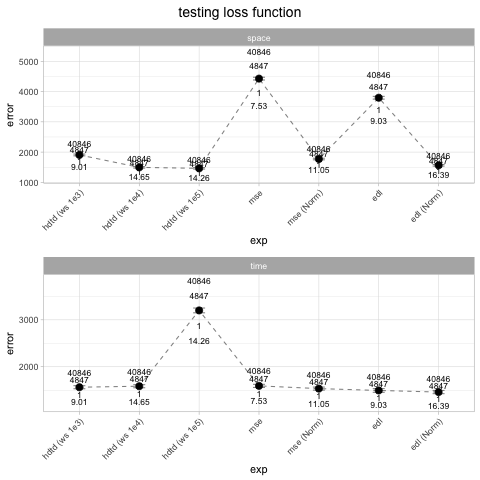

In [33]:
%%R

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("1_1_0_100000000_all"                  , "2_1_0_100000000_all"                  ,  "3_1_0_100000000_all"                  , "21_1_0_100000000_all"        , "22_1_0_100000000_all"               , "23_1_0_100000000_all"        , "24_1_0_100000000_all"               ),
            labels            = c("1_1_0_100000000_all" = "hdtd (ws 1e3)", "2_1_0_100000000_all" = "hdtd (ws 1e4)",  "3_1_0_100000000_all" = "hdtd (ws 1e5)", "21_1_0_100000000_all" = "mse", "22_1_0_100000000_all" = "mse (Norm)", "23_1_0_100000000_all" = "edl", "24_1_0_100000000_all" = "edl (Norm)"),
            limits            = c("1_1_0_100000000_all"                  , "2_1_0_100000000_all"                  ,  "3_1_0_100000000_all"                  , "21_1_0_100000000_all"        , "22_1_0_100000000_all"               , "23_1_0_100000000_all"        , "24_1_0_100000000_all"               ),
            title             = "testing loss function", 
            xlab              = "exp", 
            ylab              = "error")

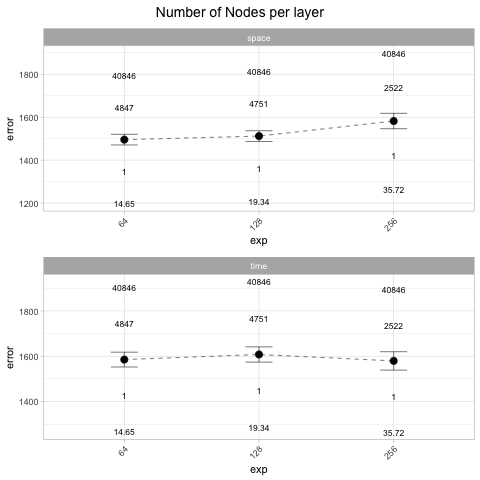

In [82]:
%%R

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("2_1_0_100000000_all"       , "7_1_0_100000000_all"        , "8_1_0_100000000_all"        ),
            labels            = c("2_1_0_100000000_all" = "64", "7_1_0_100000000_all" = "128", "8_1_0_100000000_all" = "256"),
            limits            = c("2_1_0_100000000_all"       , "7_1_0_100000000_all"        , "8_1_0_100000000_all"        ),
            title             = "Number of Nodes per layer", 
            xlab              = "exp", 
            ylab              = "error")

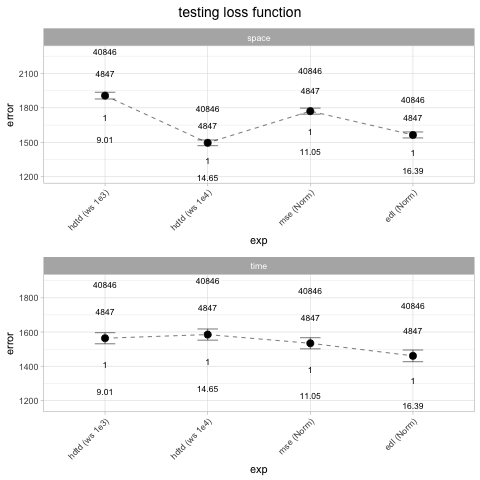

In [34]:
%%R

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("1_1_0_100000000_all"                  , "2_1_0_100000000_all"                  , "22_1_0_100000000_all"               , "24_1_0_100000000_all"               ),
            labels            = c("1_1_0_100000000_all" = "hdtd (ws 1e3)", "2_1_0_100000000_all" = "hdtd (ws 1e4)", "22_1_0_100000000_all" = "mse (Norm)", "24_1_0_100000000_all" = "edl (Norm)"),
            limits            = c("1_1_0_100000000_all"                  , "2_1_0_100000000_all"                  , "22_1_0_100000000_all"               , "24_1_0_100000000_all"               ),
            title             = "testing loss function 2", 
            xlab              = "exp", 
            ylab              = "error")

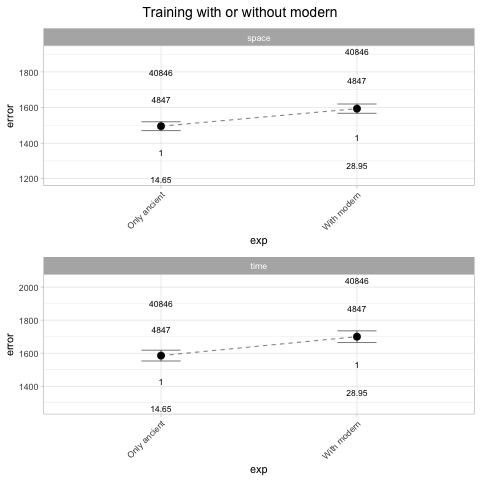

In [129]:
%%R

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("2_1_0_100000000_all"                 , "9_1_0_100000000_all"        ),
            labels            = c("2_1_0_100000000_all" = "Only ancient", "9_1_0_100000000_all" = "With modern"),
            limits            = c("2_1_0_100000000_all"                 , "9_1_0_100000000_all"        ),
            title             = "Training with or without modern", 
            xlab              = "exp", 
            ylab              = "error")

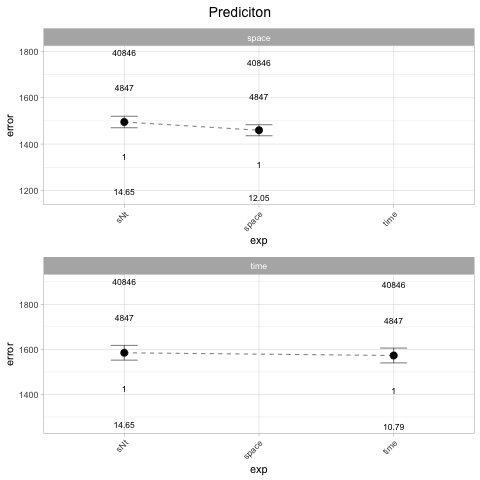

In [320]:
%%R

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("2_1_0_100000000_all"        , "5_1_0_100000000_all"          , "6_1_0_100000000_all"         ),
            labels            = c("2_1_0_100000000_all" = "sNt", "5_1_0_100000000_all" = "space", "6_1_0_100000000_all" = "time"),
            limits            = c("2_1_0_100000000_all"        , "5_1_0_100000000_all"          , "6_1_0_100000000_all"         ),
            title             = "Prediciton", 
            xlab              = "exp", 
            ylab              = "error")

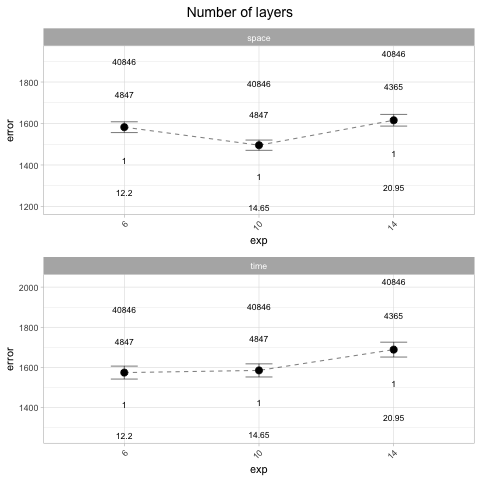

In [69]:
%%R

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("25_1_0_100000000_all"      , "2_1_0_100000000_all"       , "26_1_0_100000000_all"       ),
            labels            = c("25_1_0_100000000_all" = "6", "2_1_0_100000000_all" = "10", "26_1_0_100000000_all" = "14"),
            limits            = c("25_1_0_100000000_all"      , "2_1_0_100000000_all"       , "26_1_0_100000000_all"       ),
            title             = "Number of layers", 
            xlab              = "exp", 
            ylab              = "error")

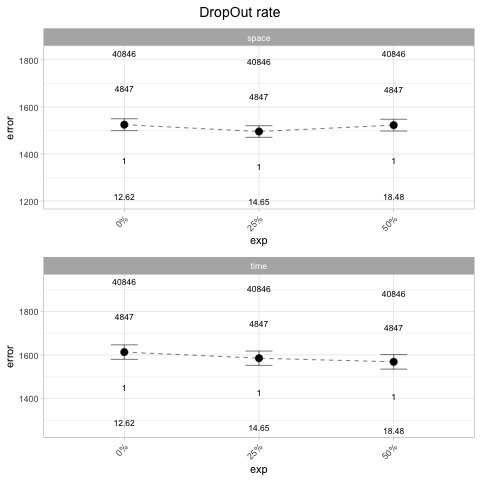

In [68]:
%%R

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("27_1_0_100000000_all"       , "2_1_0_100000000_all"        , "28_1_0_100000000_all"       ),
            labels            = c("27_1_0_100000000_all" = "0%", "2_1_0_100000000_all" = "25%", "28_1_0_100000000_all" = "50%"),
            limits            = c("27_1_0_100000000_all"       , "2_1_0_100000000_all"        , "28_1_0_100000000_all"       ),
            title             = "DropOut rate", 
            xlab              = "exp", 
            ylab              = "error")

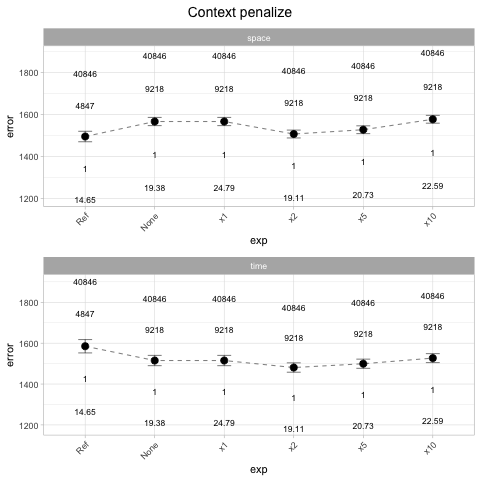

In [134]:
%%R

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("2_1_0_100000000_all"        , "15_1_0_100000000_all"         , "16_1_0_100000000_all"       , "17_1_0_100000000_all"       , "18_1_0_100000000_all"       , "19_1_0_100000000_all"        ),
            labels            = c("2_1_0_100000000_all" = "Ref", "15_1_0_100000000_all" = "None", "16_1_0_100000000_all" = "x1", "17_1_0_100000000_all" = "x2", "18_1_0_100000000_all" = "x5", "19_1_0_100000000_all" = "x10"),
            limits            = c("2_1_0_100000000_all"        , "15_1_0_100000000_all"         , "16_1_0_100000000_all"       , "17_1_0_100000000_all"       , "18_1_0_100000000_all"       , "19_1_0_100000000_all"        ),
            title             = "Context penalize", 
            xlab              = "exp", 
            ylab              = "error")

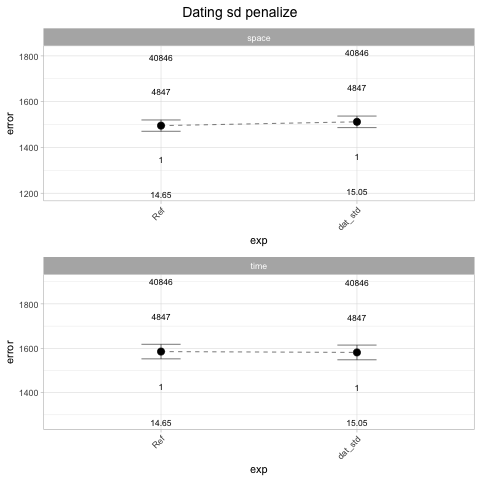

In [71]:
%%R

plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("2_1_0_100000000_all"        , "20_1_0_100000000_all"            ),
            labels            = c("2_1_0_100000000_all" = "Ref", "20_1_0_100000000_all" = "dat_std"),
            limits            = c("2_1_0_100000000_all"        , "20_1_0_100000000_all"            ),
            title             = "Dating sd penalize", 
            xlab              = "exp", 
            ylab              = "error")

In [ ]:
#14  10            tims  10   1   0  300  100
#15  10            tims  10   2   0  300  100
#16  10            tims  10   1   0 1000 1000
#17  10            tims  10   2   0 1000 1000
#18  11   tims_nomodern  11   1   0  300  100
#19  11   tims_nomodern  11   2   0  300  100
#20  11   tims_nomodern  11   1   0 1000 1000
#21  11   tims_nomodern  11   2   0 1000 1000

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


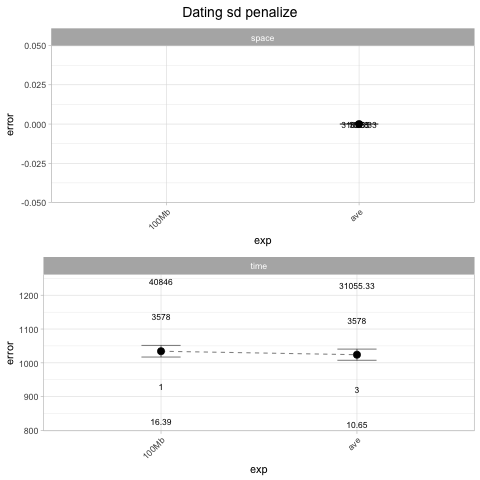

In [135]:
%%R
#"4_all_0_250000000_10000000_meaw"
plot_errors(all_scenarios_all = rbind(all_scenarios %>% ungroup(), error_spaceNNtime_mean_windows_per_chro_df %>% ungroup(), error_spaceNNtime_mean_windows_df %>% ungroup()), 
            exp_to_plot       = c("10_1_0_100000000_all"          , "10_1_0_300000000_100000000_meaw"        ),
            labels            = c("10_1_0_100000000_all" = "100Mb", "10_1_0_300000000_100000000_meaw" = "ave"),
            limits            = c("10_1_0_100000000_all"          , "10_1_0_300000000_100000000_meaw"        ),
            title             = "Dating sd penalize", 
            xlab              = "exp", 
            ylab              = "error")

#### Explaining sNNt errors

In [140]:
%%R

read.csv("../../files/AADR_filtered_metadata.txt", header = T, sep = "\t") %>%
    filter(indivi == "PCA001")



  indivi master datmet datmea datstd                     locate       countr
1 PCA001 PCA001 Direct   1367     21 Humacao,__Punta__Candelero Puerto__Rico
  latitu  longit warnin timind sntind
1 18.094 -65.789     ..  FALSE   TRUE


 [1] "BRC010.SG"        "PN06.SG"          "I2637"            "I1853"           
 [5] "RISE374_noUDG.SG" "AKB001"           "MIB030"           "I4420"           
 [9] "PCA001"           "R1286.SG"        


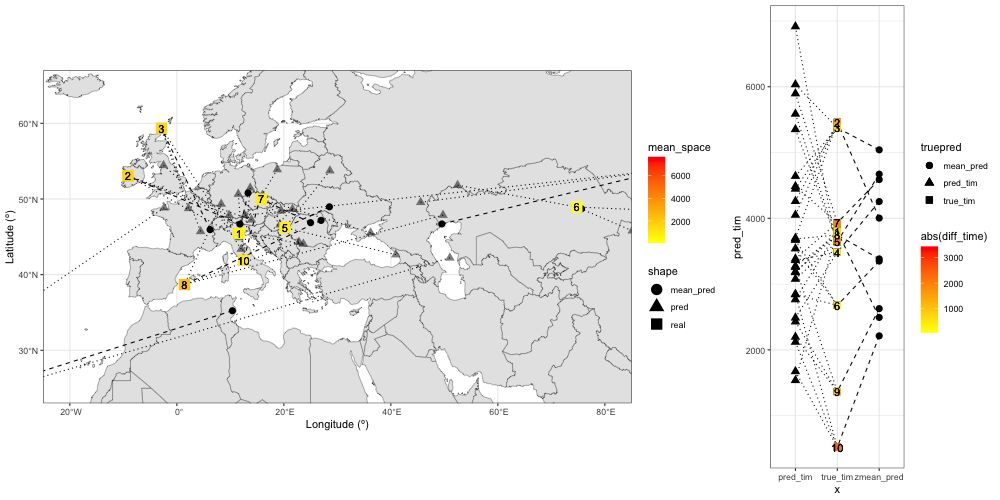

In [312]:
%%R -w 1000 -h 500

exp = "2"
sim = "AADR"
chro = "1"
sta = "0"
end = "300000000"
win = "100000000"
set.seed(1234)
#set.seed(2342)

read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
    select(ind) %>%
    distinct() %>%
    sample_n(10, replace = FALSE) %>%
    pull(ind)-> selected_ind

print(selected_ind)

plot_grid(
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_segment(aes(x = pred_lon, xend = true_lon, y = pred_lat, yend = true_lat), linetype = "dotted") +
        geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                     aes(x = mean_pred_lon, xend = true_lon, y = mean_pred_lat, yend = true_lat), linetype = "dashed") +
        #geom_point(aes(x = true_lon, y = true_lat,  shape = "real", color = diff_space),  size = 5) +
        geom_point(aes(x = pred_lon, y = pred_lat,  shape = "pred"),  size = 3, alpha = 0.5) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                    aes(x = mean_pred_lon, y = mean_pred_lat,  shape = "mean_pred"), size = 3) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                    aes(x = true_lon, y = true_lat,  shape = "real", color = mean_space), size = 5) +
        geom_text(aes(x = true_lon, y = true_lat,  label = num)) +
        coord_sf(ylim = c(25, 65), xlim = c(-20, 80)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        xlab("Longitude (º)") +
        ylab("Latitude (º)") +
        theme_bw(),
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        #select(sim, exp, nam, typ, gro, ind, pop, idx, snp, true_tim, pred_tim) %>%
        gather("truepred", "value", c(true_tim, pred_tim)) %>% 
        ggplot() +
        geom_segment(data = . %>% spread(truepred, value), aes(x = "pred_tim", xend = "true_tim", y = pred_tim, yend = true_tim), linetype = "dotted") +
        geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
                     aes(x = "zmean_pred", xend = "true_tim", y = mean_pred_tim, yend = true_tim), linetype = "dashed") +
        geom_point(aes(x = truepred, y = value, shape = truepred), size = 3) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
                    aes(x = "zmean_pred", y = mean_pred_tim, shape = "mean_pred"), size = 3) +
        geom_point(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, shape = truepred, color = abs(diff_time)), size = 3) +
        geom_text(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, label = num)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        theme_bw(),
    nrow = 1, rel_widths = c(4, 1.5))

  [1] "LHA001"                        "TAP002_noUDG"                 
  [3] "MAL006_noUDG"                  "I1368"                        
  [5] "MAL008_noUDG"                  "I1369"                        
  [7] "I16822"                        "TAP004_noUDG"                 
  [9] "MAL001_noUDG"                  "I1370"                        
 [11] "TAP003"                        "I2550"                        
 [13] "I2233"                         "I2232"                        
 [15] "I18498_noUDG"                  "I2717"                        
 [17] "I9056_noUDG_d"                 "I2543"                        
 [19] "I19167"                        "I1124"                        
 [21] "Ma554.WGC"                     "TAN002"                       
 [23] "I16821"                        "I9057_noUDG_d"                
 [25] "I9055_noUDG_d"                 "I2719"                        
 [27] "I2539"                         "I0977"                        
 [29] "SMP5_noUDG.SG

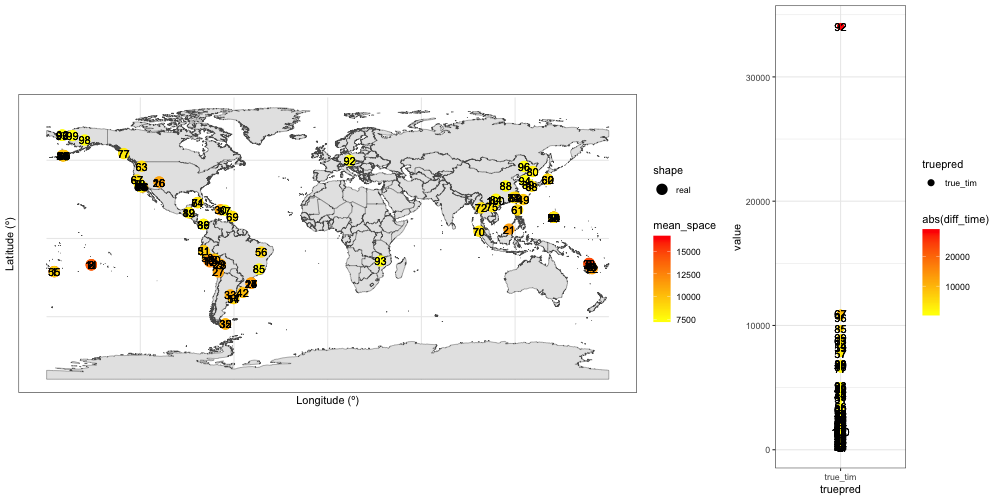

In [313]:
%%R -w 1000 -h 500

exp = "2"
sim = "AADR"
chro = "1"
sta = "0"
end = "300000000"
win = "100000000"
set.seed(1234)
#set.seed(2342)

read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
    filter(pred_lat > 90 | pred_lat < -90 | pred_lon > 180 | pred_lon < -180) %>%
    count(ind) %>%
    pull(ind) -> outworld_ind

error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
    filter(!ind %in% c(outworld_ind), extendedexp == "2_1_0_300000000_100000000") %>%
    slice_max(mean_space, n = 100) %>%
    select(ind) %>%
    distinct() %>%
    pull(ind) -> selected_ind

print(selected_ind)

plot_grid(
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        #geom_segment(aes(x = pred_lon, xend = true_lon, y = pred_lat, yend = true_lat), linetype = "dotted") +
        #geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
        #             aes(x = mean_pred_lon, xend = true_lon, y = mean_pred_lat, yend = true_lat), linetype = "dashed") +
        #geom_point(aes(x = pred_lon, y = pred_lat,  shape = "pred"),  size = 3, alpha = 0.5) +
        #geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
        #            aes(x = mean_pred_lon, y = mean_pred_lat,  shape = "mean_pred"), size = 3) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                    aes(x = true_lon, y = true_lat,  shape = "real", color = mean_space), size = 5) +
        geom_text(aes(x = true_lon, y = true_lat,  label = num)) +
        #coord_sf(ylim = c(25, 65), xlim = c(-20, 80)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        xlab("Longitude (º)") +
        ylab("Latitude (º)") +
        theme_bw(),
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        #select(sim, exp, nam, typ, gro, ind, pop, idx, snp, true_tim, pred_tim) %>%
        gather("truepred", "value", c(true_tim, pred_tim)) %>% 
        ggplot() +
        #geom_segment(data = . %>% spread(truepred, value), aes(x = "pred_tim", xend = "true_tim", y = pred_tim, yend = true_tim), linetype = "dotted") +
        #geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
        #             aes(x = "zmean_pred", xend = "true_tim", y = mean_pred_tim, yend = true_tim), linetype = "dashed") +
        #geom_point(aes(x = truepred, y = value, shape = truepred), size = 3) +
        #geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
        #            aes(x = "zmean_pred", y = mean_pred_tim, shape = "mean_pred"), size = 3) +
        geom_point(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, shape = truepred, color = abs(diff_time)), size = 3) +
        geom_text(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, label = num)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        theme_bw(),
    nrow = 1, rel_widths = c(4, 1.5))

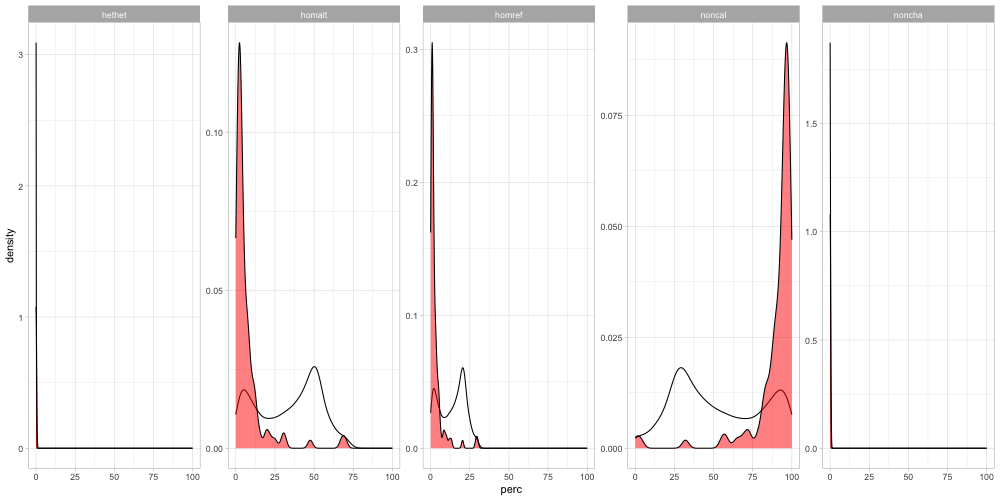

In [314]:
%%R -w 1000 -h 500

read.table("../../sandbox/AADR/4/qc_ind_1_0_1000000000.txt", col.names = c("ind", "noncal", "homref", "hethet", "homalt", "noncha")) %>%
    gather("type", "count", 2:6) %>%
    group_by(ind) %>%
    mutate(perc = 100*count/sum(count)) %>% 
    ggplot() +
    geom_density(aes(x = perc)) +
    geom_density(data = . %>%  filter(ind %in% selected_ind), aes(x = perc), fill = "red", alpha = 0.5) +
    facet_wrap(.~type, scales = "free_y", nrow = 1) +
    theme_light()

  [1] "TU875_SX9"       "I5072"           "I3715"           "ARS005.A0101"   
  [5] "JHT-30.SG"       "I11520"          "I3735"           "AED513_noUDG.SG"
  [9] "C3317"           "KNE004"          "I15676"          "I17902"         
 [13] "MX193"           "WEHR_1192SkA"    "MIB034"          "I14792"         
 [17] "PDA004"          "I2921_enhanced"  "Aes11"           "I14992"         
 [21] "MX277"           "Aes17"           "I16174"          "MIB040"         
 [25] "I5077"           "I15977"          "2H10.SG"         "C3340"          
 [29] "R3742.SG"        "POST_28"         "IMA005"          "BNL005"         
 [33] "MX283_d"         "Alh2_noUDG.SG"   "AKB001"          "ALT-77.SG"      
 [37] "I8549"           "MIB045"          "R6756.SG"        "I12969"         
 [41] "Aes4"            "I4354_noUDG"     "MX298"           "C3314"          
 [45] "BRE005"          "I6545"           "I15968"          "ULA001"         
 [49] "RA58"            "C1711"           "OBR004"          "C62

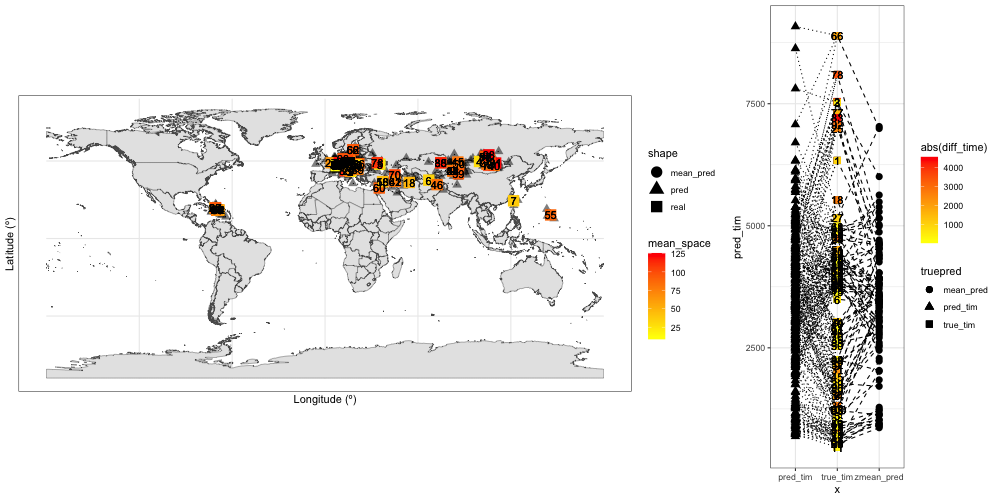

In [315]:
%%R -w 1000 -h 500

exp = "2"
sim = "AADR"
chro = "1"
sta = "0"
end = "300000000"
win = "100000000"
set.seed(1234)
#set.seed(2342)

read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
    filter(pred_lat > 90 | pred_lat < -90 | pred_lon > 180 | pred_lon < -180) %>%
    count(ind) %>%
    pull(ind) -> outworld_ind

error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
    filter(!ind %in% c(outworld_ind), extendedexp == "2_1_0_300000000_100000000") %>%
    slice_min(mean_space, n = 100) %>%
    select(ind) %>%
    distinct() %>%
    pull(ind) -> selected_ind

print(selected_ind)

plot_grid(
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_segment(aes(x = pred_lon, xend = true_lon, y = pred_lat, yend = true_lat), linetype = "dotted") +
        geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                     aes(x = mean_pred_lon, xend = true_lon, y = mean_pred_lat, yend = true_lat), linetype = "dashed") +
        geom_point(aes(x = pred_lon, y = pred_lat,  shape = "pred"),  size = 3, alpha = 0.5) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                    aes(x = mean_pred_lon, y = mean_pred_lat,  shape = "mean_pred"), size = 3) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                    aes(x = true_lon, y = true_lat,  shape = "real", color = mean_space), size = 5) +
        geom_text(aes(x = true_lon, y = true_lat,  label = num)) +
        #coord_sf(ylim = c(25, 65), xlim = c(-20, 80)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        xlab("Longitude (º)") +
        ylab("Latitude (º)") +
        theme_bw(),
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        #select(sim, exp, nam, typ, gro, ind, pop, idx, snp, true_tim, pred_tim) %>%
        gather("truepred", "value", c(true_tim, pred_tim)) %>% 
        ggplot() +
        geom_segment(data = . %>% spread(truepred, value), aes(x = "pred_tim", xend = "true_tim", y = pred_tim, yend = true_tim), linetype = "dotted") +
        geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
                     aes(x = "zmean_pred", xend = "true_tim", y = mean_pred_tim, yend = true_tim), linetype = "dashed") +
        geom_point(aes(x = truepred, y = value, shape = truepred), size = 3) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
                    aes(x = "zmean_pred", y = mean_pred_tim, shape = "mean_pred"), size = 3) +
        geom_point(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, shape = truepred, color = abs(diff_time)), size = 3) +
        geom_text(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, label = num)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        theme_bw(),
    nrow = 1, rel_widths = c(4, 1.5))

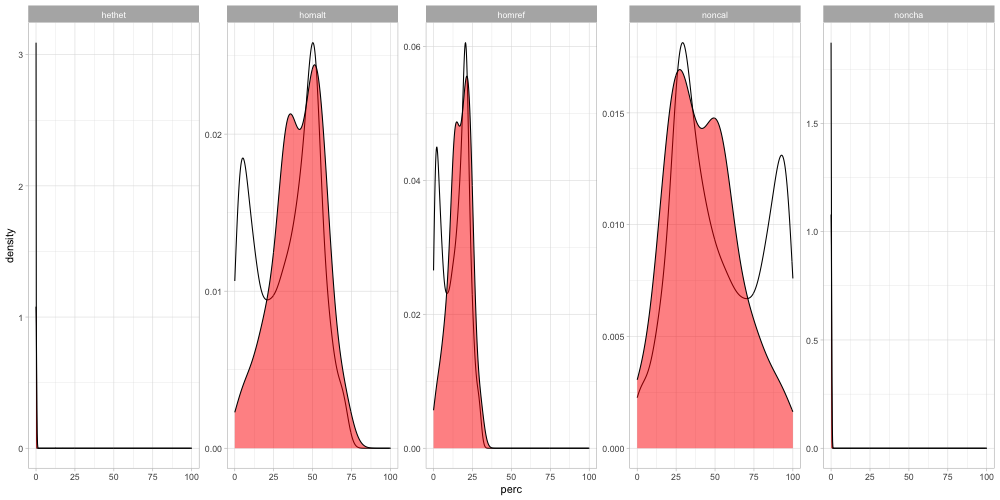

In [316]:
%%R -w 1000 -h 500

read.table("../../sandbox/AADR/4/qc_ind_1_0_1000000000.txt", col.names = c("ind", "noncal", "homref", "hethet", "homalt", "noncha")) %>%
    gather("type", "count", 2:6) %>%
    group_by(ind) %>%
    mutate(perc = 100*count/sum(count)) %>% 
    ggplot() +
    geom_density(aes(x = perc)) +
    geom_density(data = . %>%  filter(ind %in% selected_ind), aes(x = perc), fill = "red", alpha = 0.5) +
    facet_wrap(.~type, scales = "free_y", nrow = 1) +
    theme_light()

  [1] "AA7-738_noUDG"                     "CC7-2289_noUDG"                   
  [3] "CC7-335_noUDG"                     "BB7-240_noUDG"                    
  [5] "Oase1_d"                           "salkhit1_noUDG.SG"                
  [7] "Tianyuan"                          "Cioclovina1_noUDG"                
  [9] "Muierii2_d"                        "Sunghir1_noUDG.SG"                
 [11] "NE20_noUDG"                        "ZKU002_noUDG.SG"                  
 [13] "Ostuni2_d"                         "GoyetQ116-1_noUDG"                
 [15] "GoyetQ53-1_noUDG"                  "GoyetQ376-19_noUDG_d"             
 [17] "GoyetQ56-16_noUDG"                 "Ostuni1_d"                        
 [19] "MA1_noUDG.SG"                      "PM1"                              
 [21] "NE56_noUDG"                        "Sunghir4_noUDG.SG"                
 [23] "yak025_noUDG.SG"                   "RIP001_noUDG"                     
 [25] "AfontovaGora3_noUDG_d"             "AfontovaGora2_noUDG.S

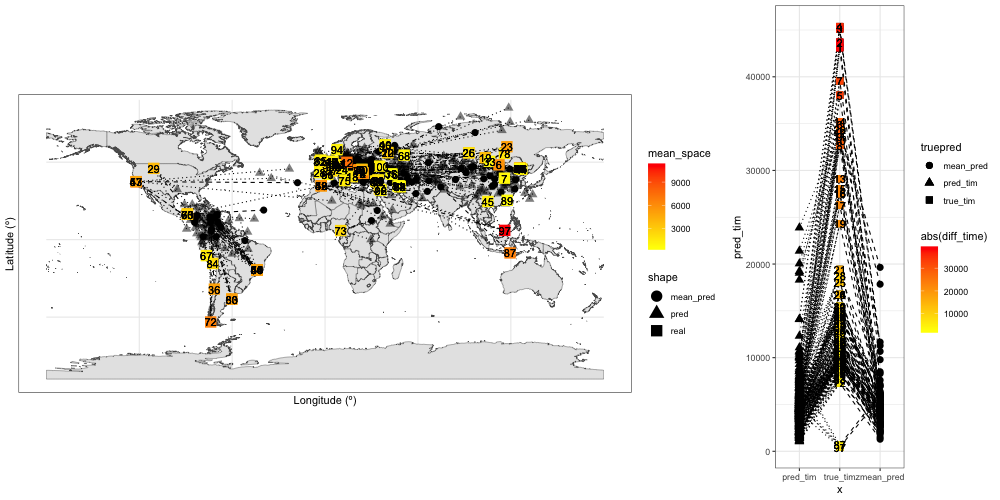

In [317]:
%%R -w 1000 -h 500

exp = "2"
sim = "AADR"
chro = "1"
sta = "0"
end = "300000000"
win = "100000000"
set.seed(1234)
#set.seed(2342)

read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
    filter(pred_lat > 90 | pred_lat < -90 | pred_lon > 180 | pred_lon < -180) %>%
    count(ind) %>%
    pull(ind) -> outworld_ind

error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
    filter(extendedexp == "2_1_0_300000000_100000000") %>%
    filter(!ind %in% c(outworld_ind)) %>%
    slice_max(mean_time, n = 100) %>%
    select(ind) %>%
    distinct() %>%
    pull(ind) -> selected_ind

print(selected_ind)

plot_grid(
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_segment(aes(x = pred_lon, xend = true_lon, y = pred_lat, yend = true_lat), linetype = "dotted") +
        geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                     aes(x = mean_pred_lon, xend = true_lon, y = mean_pred_lat, yend = true_lat), linetype = "dashed") +
        geom_point(aes(x = pred_lon, y = pred_lat,  shape = "pred"),  size = 3, alpha = 0.5) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                    aes(x = mean_pred_lon, y = mean_pred_lat,  shape = "mean_pred"), size = 3) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                    aes(x = true_lon, y = true_lat,  shape = "real", color = mean_space), size = 5) +
        geom_text(aes(x = true_lon, y = true_lat,  label = num)) +
        #coord_sf(ylim = c(25, 65), xlim = c(-20, 80)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        xlab("Longitude (º)") +
        ylab("Latitude (º)") +
        theme_bw(),
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        #select(sim, exp, nam, typ, gro, ind, pop, idx, snp, true_tim, pred_tim) %>%
        gather("truepred", "value", c(true_tim, pred_tim)) %>% 
        ggplot() +
        geom_segment(data = . %>% spread(truepred, value), aes(x = "pred_tim", xend = "true_tim", y = pred_tim, yend = true_tim), linetype = "dotted") +
        geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
                     aes(x = "zmean_pred", xend = "true_tim", y = mean_pred_tim, yend = true_tim), linetype = "dashed") +
        geom_point(aes(x = truepred, y = value, shape = truepred), size = 3) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
                    aes(x = "zmean_pred", y = mean_pred_tim, shape = "mean_pred"), size = 3) +
        geom_point(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, shape = truepred, color = abs(diff_time)), size = 3) +
        geom_text(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, label = num)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        theme_bw(),
    nrow = 1, rel_widths = c(4, 1.5))

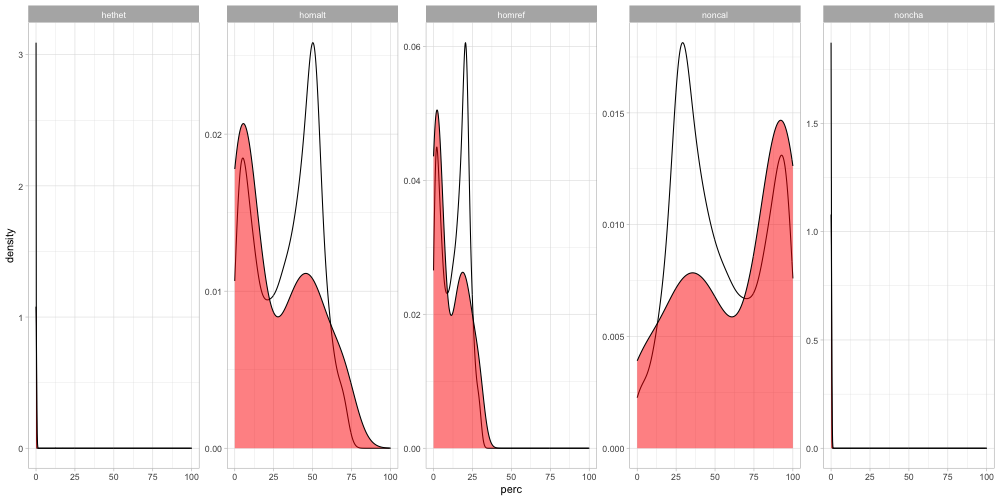

In [318]:
%%R -w 1000 -h 500

read.table("../../sandbox/AADR/4/qc_ind_1_0_1000000000.txt", col.names = c("ind", "noncal", "homref", "hethet", "homalt", "noncha")) %>%
    gather("type", "count", 2:6) %>%
    group_by(ind) %>%
    mutate(perc = 100*count/sum(count)) %>% 
    ggplot() +
    geom_density(aes(x = perc)) +
    geom_density(data = . %>%  filter(ind %in% selected_ind), aes(x = perc), fill = "red", alpha = 0.5) +
    facet_wrap(.~type, scales = "free_y", nrow = 1) +
    theme_light()

  [1] "I5890"             "C3344"             "PN16.SG"          
  [4] "MIS001"            "MIB062"            "I7045"            
  [7] "CBR004"            "I14677"            "R3664.SG"         
 [10] "CAO024"            "Enoque65_noUDG.SG" "KO1009"           
 [13] "I14377"            "I2443"             "I4776"            
 [16] "TW063"             "I20622"            "I19287"           
 [19] "I4312"             "I1765_d"           "R10840.SG"        
 [22] "I7411"             "I26628"            "NIK004_noUDG.SG"  
 [25] "PS-06_noUDG.SG"    "VLI051"            "I2653"            
 [28] "I6292"             "I6718"             "C2049"            
 [31] "PMI006"            "I15595"            "MIB009"           
 [34] "I6556"             "CO001"             "I1027"            
 [37] "I2416"             "C1194"             "I2163"            
 [40] "MIB064"            "VK531_noUDG.SG"    "N4b2_noUDG.SG"    
 [43] "IR1_noUDG.SG"      "I14875"            "I14784"           
 [46] "vbj

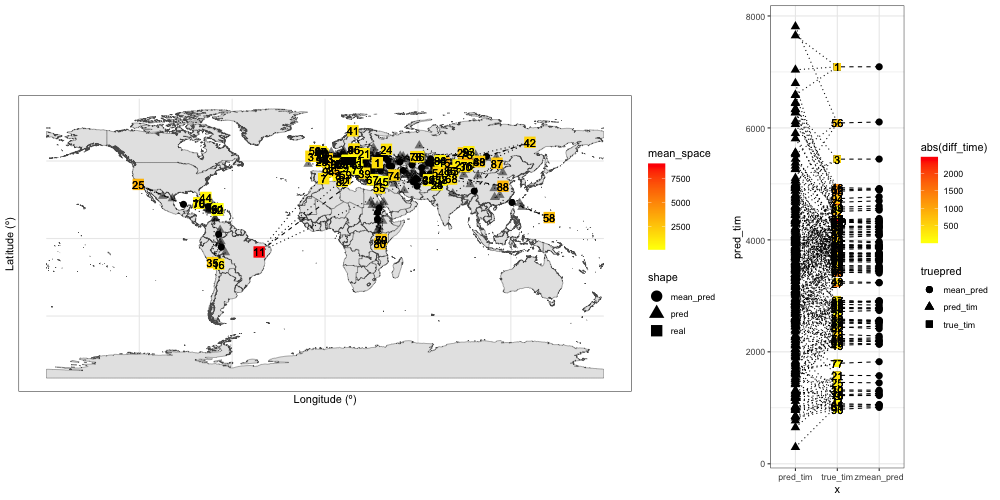

In [231]:
%%R -w 1000 -h 500

exp = "2"
sim = "AADR"
chro = "1"
sta = "0"
end = "300000000"
win = "100000000"
set.seed(1234)
#set.seed(2342)

read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
    filter(pred_lat > 90 | pred_lat < -90 | pred_lon > 180 | pred_lon < -180) %>%
    count(ind) %>%
    pull(ind) -> outworld_ind

error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
    filter(extendedexp == "2_1_0_300000000_100000000") %>%
    slice_min(mean_time, n = 100) %>%
    select(ind) %>%
    distinct() %>%
    pull(ind) -> selected_ind

print(selected_ind)

plot_grid(
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_segment(aes(x = pred_lon, xend = true_lon, y = pred_lat, yend = true_lat), linetype = "dotted") +
        geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                     aes(x = mean_pred_lon, xend = true_lon, y = mean_pred_lat, yend = true_lat), linetype = "dashed") +
        geom_point(aes(x = pred_lon, y = pred_lat,  shape = "pred"),  size = 3, alpha = 0.5) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                    aes(x = mean_pred_lon, y = mean_pred_lat,  shape = "mean_pred"), size = 3) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") , 
                    aes(x = true_lon, y = true_lat,  shape = "real", color = mean_space), size = 5) +
        geom_text(aes(x = true_lon, y = true_lat,  label = num)) +
        #coord_sf(ylim = c(25, 65), xlim = c(-20, 80)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        xlab("Longitude (º)") +
        ylab("Latitude (º)") +
        theme_bw(),
    read.table(paste("../../sandbox/", sim, "/", exp, "/pred_", chro, "_", sta, "_", end, "_", win, ".txt", sep = ""), header = T) %>%
        filter(ind %in% selected_ind) %>%
        left_join(data.frame(ind = selected_ind, num = 1:length(selected_ind)), by = c("ind")) %>%
        #select(sim, exp, nam, typ, gro, ind, pop, idx, snp, true_tim, pred_tim) %>%
        gather("truepred", "value", c(true_tim, pred_tim)) %>% 
        ggplot() +
        geom_segment(data = . %>% spread(truepred, value), aes(x = "pred_tim", xend = "true_tim", y = pred_tim, yend = true_tim), linetype = "dotted") +
        geom_segment(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
                     aes(x = "zmean_pred", xend = "true_tim", y = mean_pred_tim, yend = true_tim), linetype = "dashed") +
        geom_point(aes(x = truepred, y = value, shape = truepred), size = 3) +
        geom_point(data = error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% filter(ind %in% selected_ind, extendedexp == "2_1_0_300000000_100000000") ,
                    aes(x = "zmean_pred", y = mean_pred_tim, shape = "mean_pred"), size = 3) +
        geom_point(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, shape = truepred, color = abs(diff_time)), size = 3) +
        geom_text(data = . %>% filter(truepred == "true_tim"), aes(x = truepred, y = value, label = num)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        theme_bw(),
    nrow = 1, rel_widths = c(4, 1.5))

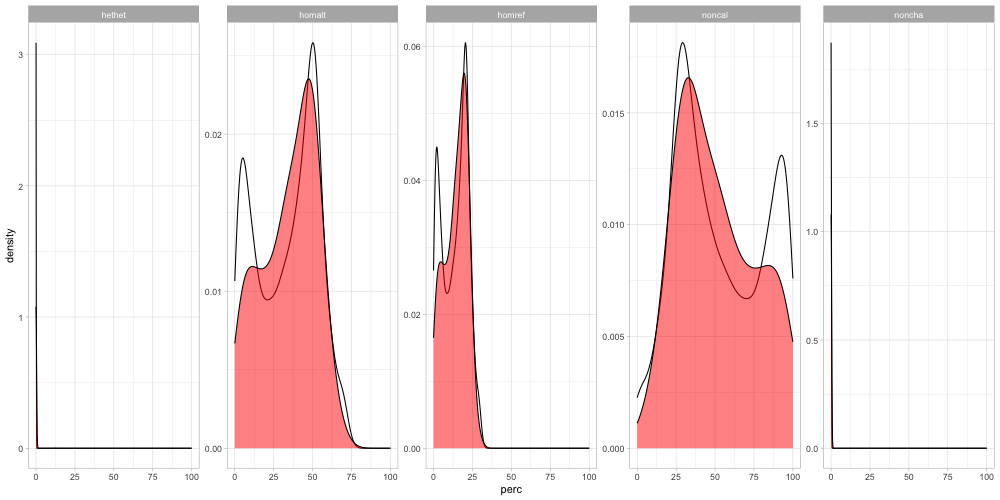

In [232]:
%%R -w 1000 -h 500

read.table("../../sandbox/AADR/4/qc_ind_1_0_1000000000.txt", col.names = c("ind", "noncal", "homref", "hethet", "homalt", "noncha")) %>%
    gather("type", "count", 2:6) %>%
    group_by(ind) %>%
    mutate(perc = 100*count/sum(count)) %>% 
    ggplot() +
    geom_density(aes(x = perc)) +
    geom_density(data = . %>%  filter(ind %in% selected_ind), aes(x = perc), fill = "red", alpha = 0.5) +
    facet_wrap(.~type, scales = "free_y", nrow = 1) +
    theme_light()

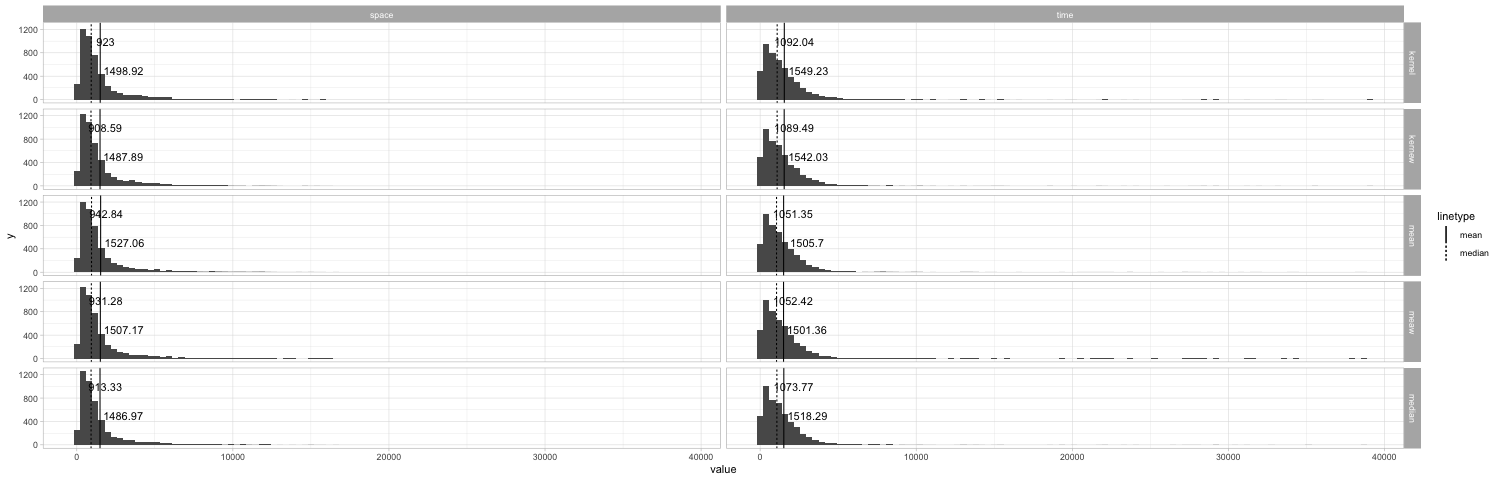

In [284]:
%%R -w 1500

error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
    #filted(ind %in% selected_ind) %>%
    filter(extendedexp == "2_1_0_300000000_100000000") %>%
    select(29:38) %>%
    gather("stat", "value", 1:10) %>%
    separate(stat, c("aver", "stat")) %>%
    ggplot() +
    geom_histogram(aes(x = value), bins = 100) +
    geom_vline(data = . %>% group_by(aver, stat) %>% summarize(mean = mean(value)), aes(xintercept = mean, linetype = "mean")) +
    geom_text(data = . %>% group_by(aver, stat) %>% summarize(mean = mean(value)), aes(y = 500, x = mean*2, label = round(mean, 2))) +
    geom_vline(data = . %>% group_by(aver, stat) %>% summarize(median = median(value)), aes(xintercept = median, linetype = "median")) +
    geom_text(data = . %>% group_by(aver, stat) %>% summarize(median = median(value)), aes(y = 1000, x = median*2, label = round(median, 2))) +
    facet_grid(aver~stat) +
    theme_light() 

In [151]:
%%R

error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
    filter(extendedexp == "2_1_0_300000000_100000000") %>%
    mutate(outside_lat = mean_pred_lat > 90  | mean_pred_lat < -90,
           outside_lon = mean_pred_lon > 180 | mean_pred_lon < -180) %>%
    count(outside_lat, outside_lon)

  outside_lat outside_lon    n
1       FALSE       FALSE 4841
2        TRUE       FALSE    3
3        TRUE        TRUE    3


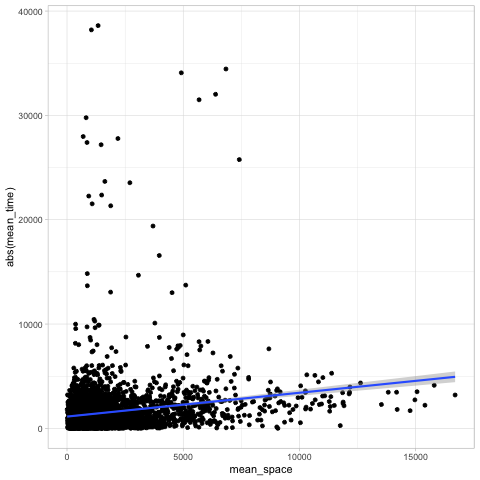

In [287]:
%%R

error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
    filter(!ind %in% outworld_ind, extendedexp == "2_1_0_300000000_100000000") %>% 
    ggplot(aes(x = mean_space, y = abs(mean_time))) +
    geom_point() +
    geom_smooth(formula = "y ~ x", method = "lm") +
    theme_light()

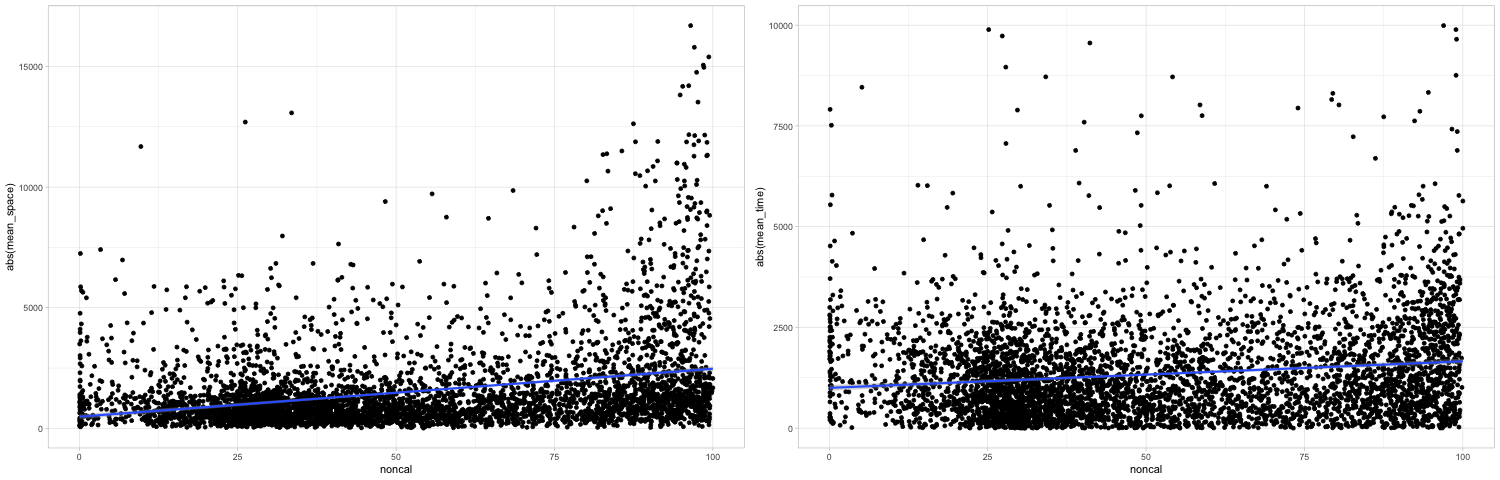

In [297]:
%%R -w 1500

n_bins = 20


read.table("../../sandbox/AADR/4/qc_ind_1_0_1000000000.txt", col.names = c("ind", "noncal", "homref", "hethet", "homalt", "noncha")) %>%
    gather("type", "count", 2:6) %>%
    group_by(ind) %>%
    mutate(perc = 100*count/sum(count)) %>%
    select(-c(count)) %>%
    spread(type, perc) -> ind_quality


plot_grid(
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        left_join(ind_quality, by = c("ind")) %>%
        ggplot(aes(x = noncal, y = abs(mean_space))) +
        geom_point() +
        geom_smooth(formula = "y ~ x", method = "lm") +
        theme_light(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        left_join(ind_quality, by = c("ind")) %>%
        filter(abs(mean_time) < 10e3) %>% ######################################
        ggplot(aes(x = noncal, y = abs(mean_time))) +
        geom_point() +
        geom_smooth(formula = "y ~ x", method = "lm") +
        theme_light())

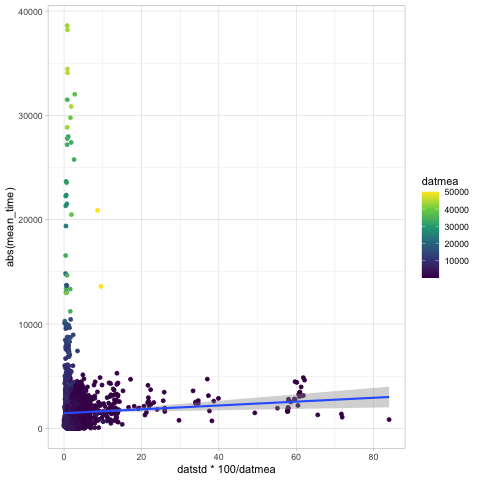

In [329]:
%%R
error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
    filter(extendedexp == "2_1_0_300000000_100000000") %>% 
    left_join(read.csv("../../files/AADR_filtered_metadata.txt", header = T, sep = "\t") %>% filter(sntind) %>% select(ind = indivi, datmea, datstd), by = c("ind")) %>%
    ggplot(aes(x = datstd*100/datmea, y = abs(mean_time))) +
    geom_point(aes(color = datmea)) +
    geom_smooth(formula = "y ~ x", method = "lm") +
    scale_color_viridis_c() +
    theme_light()

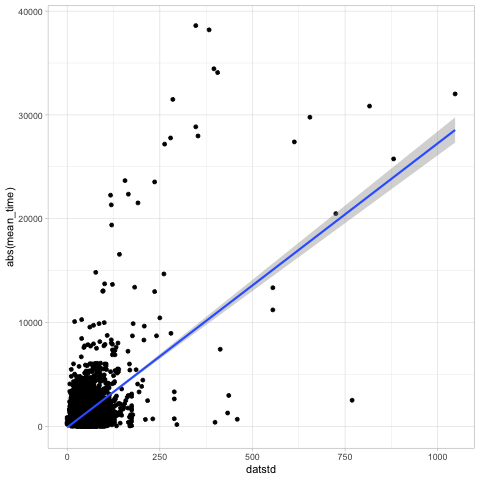

In [326]:
%%R
error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
    filter(extendedexp == "2_1_0_300000000_100000000") %>% 
    left_join(read.csv("../../files/AADR_filtered_metadata.txt", header = T, sep = "\t") %>% filter(sntind) %>% select(ind = indivi, datmea, datstd), by = c("ind")) %>%
    filter(datstd < 2000) %>%
    ggplot(aes(x = datstd, y = abs(mean_time))) +
    geom_point() +
    geom_smooth(formula = "y ~ x", method = "lm") +
    theme_light()

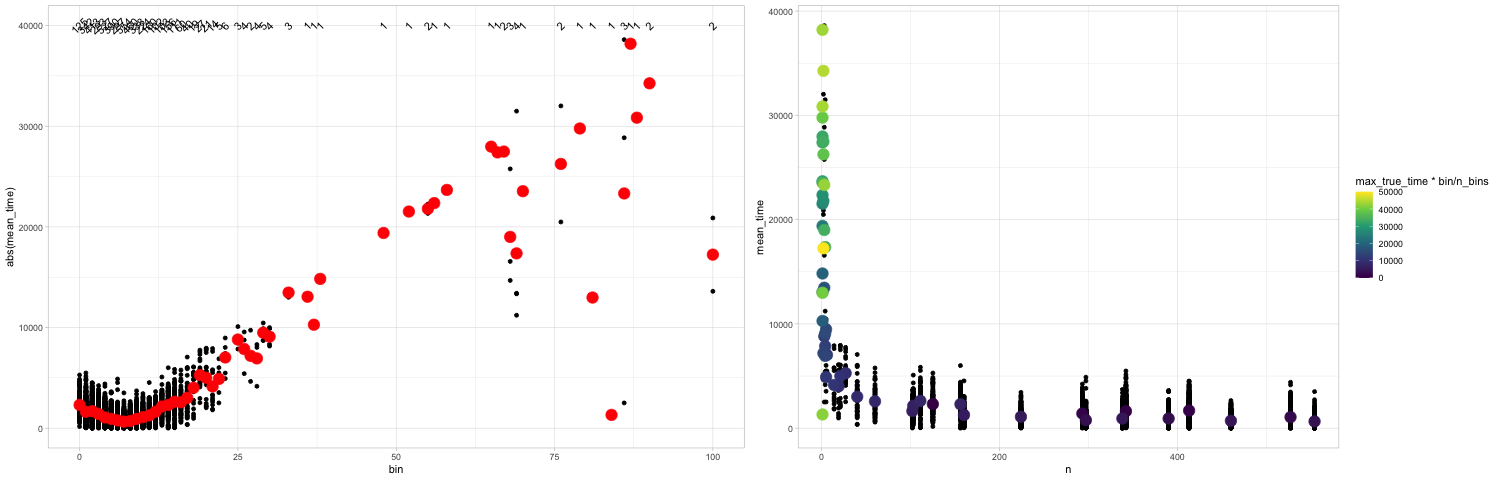

In [284]:
%%R -w 1500
n_bins = 100


error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
    filter(extendedexp == "2_1_0_300000000_100000000") %>%
    summarize(max_true_time = max(true_tim)) %>%
    pull(max_true_time) -> max_true_time

plot_grid(
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        mutate(bin = trunc(true_tim/(max_true_time/n_bins))) %>%
        ggplot() +
        geom_point(aes(x = bin, y = abs(mean_time))) +
        geom_point(data = . %>% group_by(bin) %>% summarize(mean_diff_time = mean(abs(mean_time))), aes(x = bin, y = mean_diff_time), size = 5, color = "red") +
        geom_text(data = . %>% group_by(bin) %>% summarize(n = n()), aes(x = bin, y = 40000, label = n), angle = 45) +
        theme_light(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        mutate(bin = trunc(true_tim/(max_true_time/n_bins))) %>%
        group_by(bin) %>%
        mutate(n = n()) %>%
        ggplot() +
        geom_point(aes(x = n, y = mean_time)) +
        geom_point(data = . %>% 
                            group_by(bin) %>% 
                            summarize(mean_error = mean(abs(mean_time)), 
                                      n = mean(n), 
                                      mean_time = mean(true_tim)), 
                    aes(x = n, y = mean_error, color = max_true_time*bin/n_bins), size = 5) +
        scale_color_viridis_c() +
        theme_light())

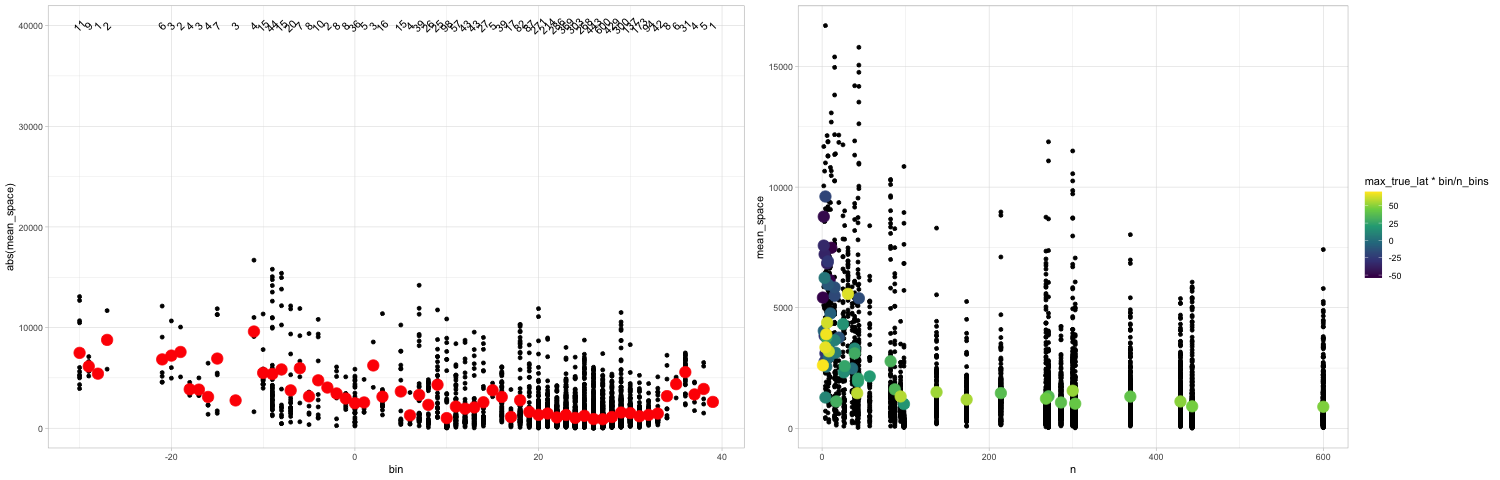

In [283]:
%%R -w 1500
n_bins = 50


max_true_lat <- 90

plot_grid(
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        mutate(bin = trunc(true_lat/(max_true_lat/n_bins))) %>%
        ggplot() +
        geom_point(aes(x = bin, y = abs(mean_space))) +
        geom_point(data = . %>% group_by(bin) %>% summarize(mean_diff_space = mean(abs(mean_space))), aes(x = bin, y = mean_diff_space), size = 5, color = "red") +
        geom_text(data = . %>% group_by(bin) %>% summarize(n = n()), aes(x = bin, y = 40000, label = n), angle = 45) +
        theme_light(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        mutate(bin = trunc(true_lat/(max_true_lat/n_bins))) %>%
        group_by(bin) %>%
        mutate(n = n()) %>%
        ggplot() +
        geom_point(aes(x = n, y = mean_space)) +
        geom_point(data = . %>% 
                            group_by(bin) %>% 
                            summarize(mean_error = mean(abs(mean_space)), 
                                      n = mean(n), 
                                      mean_time = mean(true_lat)), 
                    aes(x = n, y = mean_error, color = max_true_lat*bin/n_bins), size = 5) +
        scale_color_viridis_c() +
        theme_light())

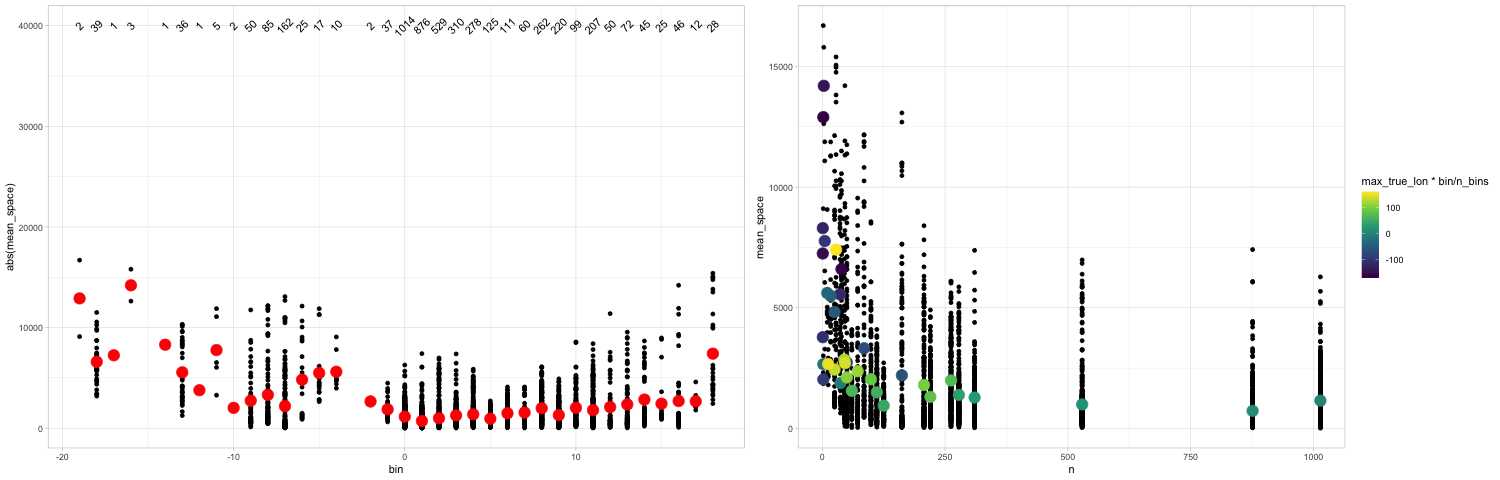

In [282]:
%%R -w 1500
n_bins = 20


max_true_lon <- 180

plot_grid(
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        mutate(bin = trunc(true_lon/(max_true_lon/n_bins))) %>%
        ggplot() +
        geom_point(aes(x = bin, y = abs(mean_space))) +
        geom_point(data = . %>% group_by(bin) %>% summarize(mean_diff_space = mean(abs(mean_space))), aes(x = bin, y = mean_diff_space), size = 5, color = "red") +
        geom_text(data = . %>% group_by(bin) %>% summarize(n = n()), aes(x = bin, y = 40000, label = n), angle = 45) +
        theme_light(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        mutate(bin = trunc(true_lon/(max_true_lon/n_bins))) %>%
        group_by(bin) %>%
        mutate(n = n()) %>%
        ggplot() +
        geom_point(aes(x = n, y = mean_space)) +
        geom_point(data = . %>% 
                            group_by(bin) %>% 
                            summarize(mean_error = mean(abs(mean_space)), 
                                      n = mean(n), 
                                      mean_time = mean(true_lon)), 
                    aes(x = n, y = mean_error, color = max_true_lon*bin/n_bins), size = 5) +
        scale_color_viridis_c() +
        theme_light())

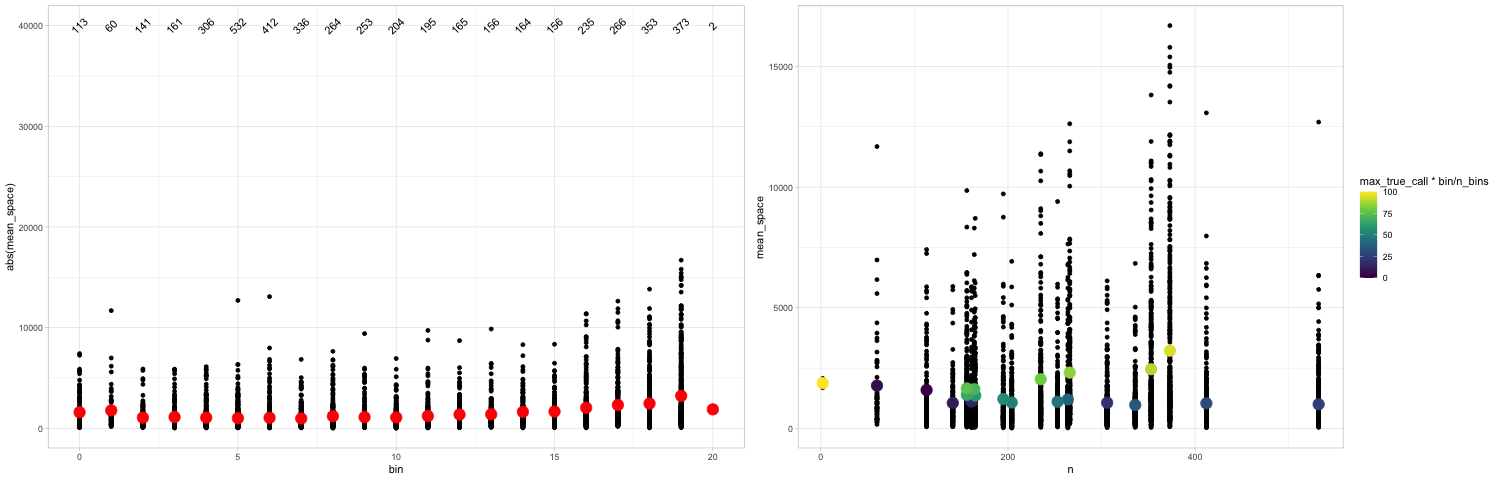

In [293]:
%%R -w 1500

n_bins = 20


read.table("../../sandbox/AADR/4/qc_ind_1_0_1000000000.txt", col.names = c("ind", "noncal", "homref", "hethet", "homalt", "noncha")) %>%
    gather("type", "count", 2:6) %>%
    group_by(ind) %>%
    mutate(perc = 100*count/sum(count)) %>%
    select(-c(count)) %>%
    spread(type, perc) -> ind_quality

max_true_call <- 100

plot_grid(
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        left_join(ind_quality, by = c("ind")) %>%
        mutate(bin = trunc(noncal/(max_true_call/n_bins))) %>%
        ggplot() +
        geom_point(aes(x = bin, y = abs(mean_space))) +
        geom_point(data = . %>% group_by(bin) %>% summarize(mean_diff_space = mean(abs(mean_space))), aes(x = bin, y = mean_diff_space), size = 5, color = "red") +
        geom_text(data = . %>% group_by(bin) %>% summarize(n = n()), aes(x = bin, y = 40000, label = n), angle = 45) +
        theme_light(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>% 
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        left_join(ind_quality, by = c("ind")) %>%
        mutate(bin = trunc(noncal/(max_true_call/n_bins))) %>%
        group_by(bin) %>%
        mutate(n = n()) %>%
        ggplot() +
        geom_point(aes(x = n, y = mean_space)) +
        geom_point(data = . %>% 
                            group_by(bin) %>% 
                            summarize(mean_error = mean(abs(mean_space)), 
                                      n = mean(n), 
                                      mean_time = mean(true_lon)), 
                    aes(x = n, y = mean_error, color = max_true_call*bin/n_bins), size = 5) +
        scale_color_viridis_c() +
        theme_light())

In [287]:
%%R

read.table("../../sandbox/AADR/4/qc_ind_1_0_1000000000.txt", col.names = c("ind", "noncal", "homref", "hethet", "homalt", "noncha")) %>%
    gather("type", "count", 2:6) %>%
    group_by(ind) %>%
    mutate(perc = 100*count/sum(count)) %>%
    select(-c(count)) %>%
    spread(type, perc) -> ind_quality

# A tibble: 6 × 6
# Groups:   ind [6]
  ind               hethet homalt homref noncal noncha
  <chr>              <dbl>  <dbl>  <dbl>  <dbl>  <dbl>
1 11KBM1.SG              0   6.85   2.59   90.6      0
2 18R21266_noUDG.EC      0   2.89   1.13   96.0      0
3 19651_noUDG.SG         0  41.8   17.2    41.0      0
4 1H04.SG                0  22.5    9.22   68.2      0
5 1H06.SG                0  31.4   12.7    55.9      0
6 1H07.SG                0  14.8    5.79   79.4      0


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


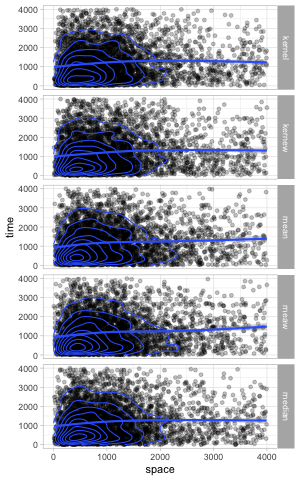

In [244]:
%%R -w 300

error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
    #filted(ind %in% selected_ind) %>%
    filter(extendedexp == "2_1_0_300000000_100000000") %>%
    select("ind", 29:38) %>%
    gather("stat", "value", 2:11) %>%
    separate(stat, c("aver", "stat")) %>%
    spread(stat, value) %>%
    ggplot() +
    geom_point(aes(x = space, y = time), alpha = 0.25) +
    geom_density_2d(aes(x = space, y = time)) +
    geom_smooth(aes(x = space, y = time)) +
    #geom_point(aes(x = log10(space), y = log10(time))) +
    #geom_density_2d(aes(x = log10(space), y = log10(time))) +
    facet_grid(aver~.) +
    xlim(c(0, 4000)) +
    ylim(c(0, 4000)) +
    theme_light() 

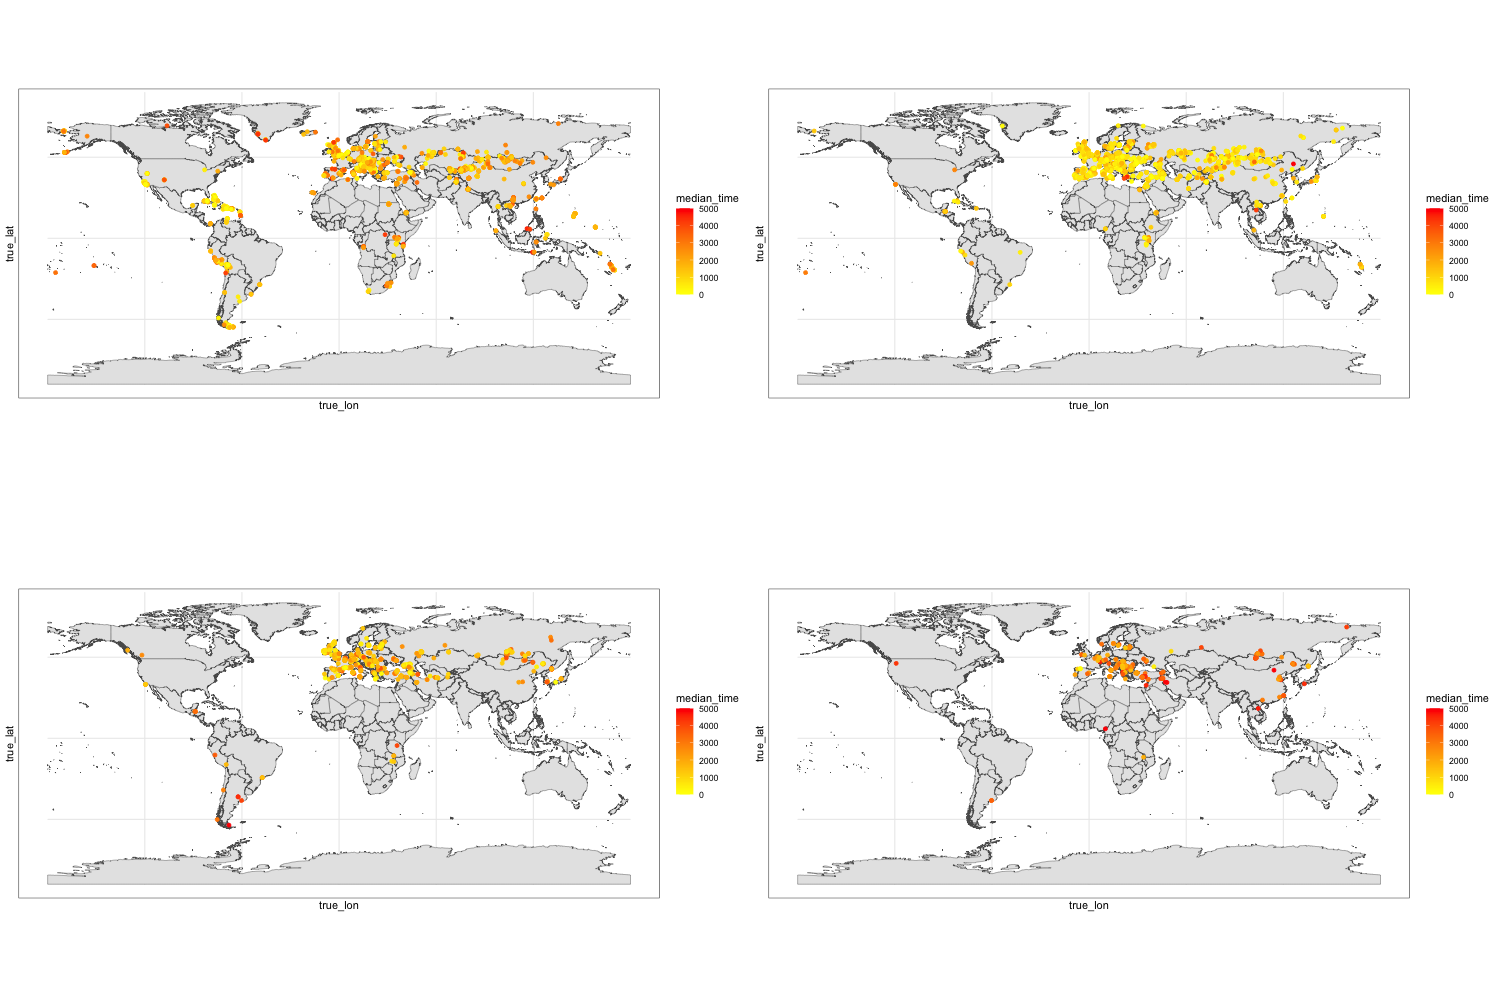

In [267]:
%%R -w 1500 -h 1000
plot_grid(
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        filter(true_tim < 2500) %>%
        filter(true_tim > 0) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = true_lon, y = true_lat, color = median_time)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA, limits = c(0, 5000)) +
        #scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
        theme_bw(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        filter(true_tim >= 2500, true_tim < 5000) %>%
        filter(true_tim > 0) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = true_lon, y = true_lat, color = median_time)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA, limits = c(0, 5000)) +
        #scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
        theme_bw(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        filter(true_tim >= 5000, true_tim < 7500) %>%
        filter(true_tim > 0) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = true_lon, y = true_lat, color = median_time)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA, limits = c(0, 5000)) +
        #scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
        theme_bw(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        filter(true_tim >= 7500) %>%
        filter(true_tim > 0) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = true_lon, y = true_lat, color = median_time)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA, limits = c(0, 5000)) +
        #scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
        theme_bw(),

    nrow = 2)



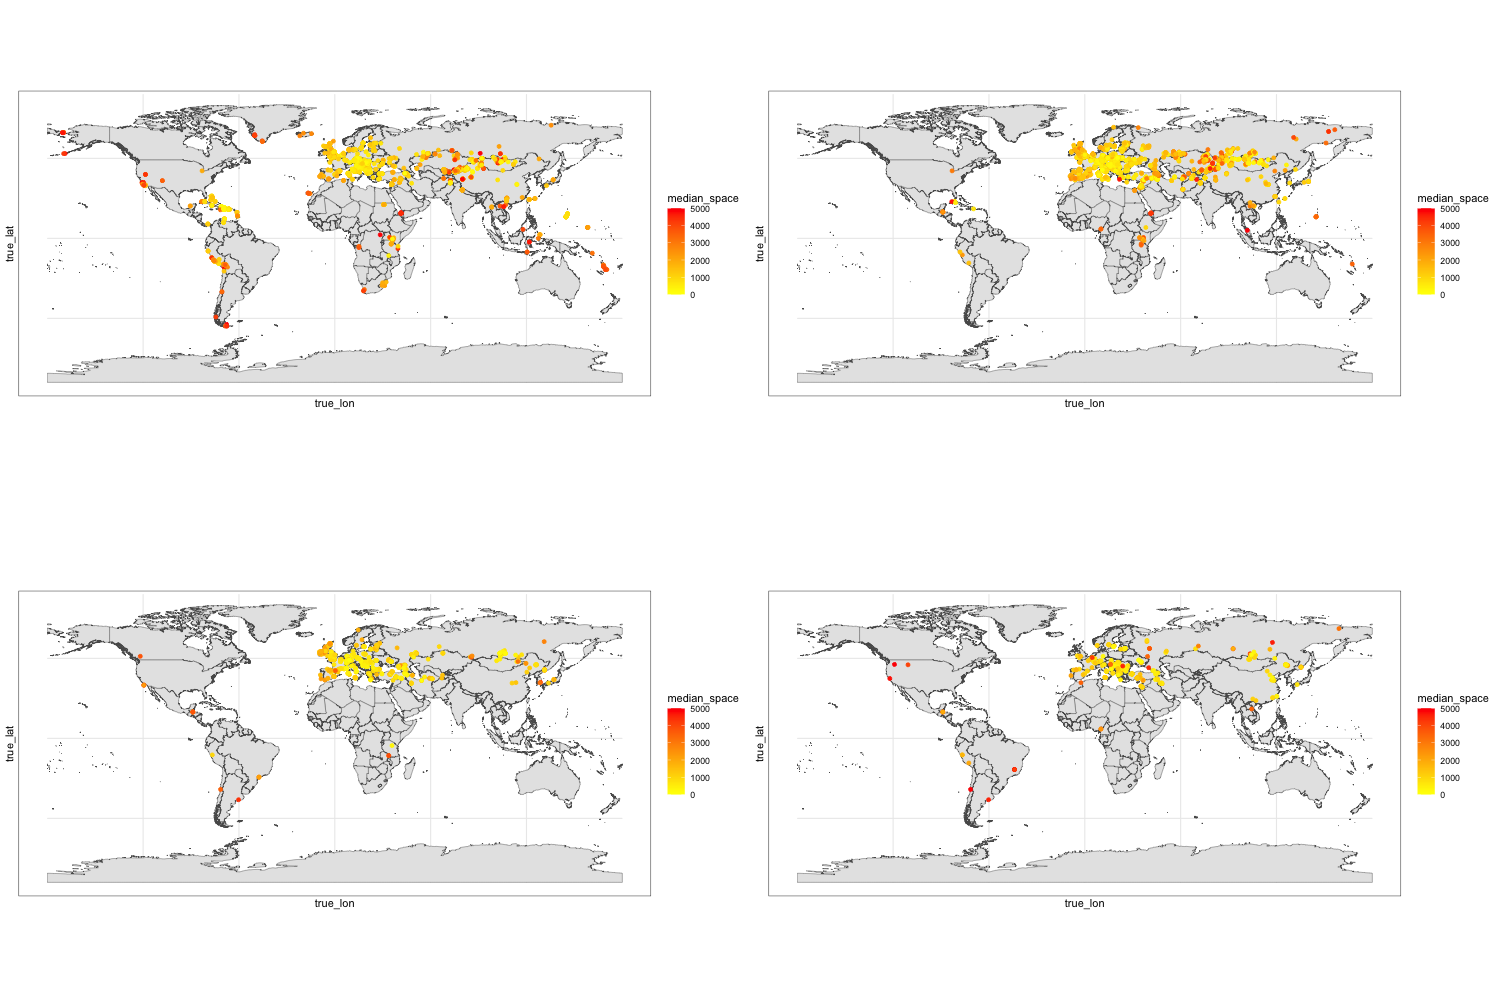

In [268]:
%%R -w 1500 -h 1000
plot_grid(
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        filter(true_tim < 2500) %>%
        filter(true_tim > 0) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = true_lon, y = true_lat, color = median_space)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA, limits = c(0, 5000)) +
        #scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
        theme_bw(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        filter(true_tim >= 2500, true_tim < 5000) %>%
        filter(true_tim > 0) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = true_lon, y = true_lat, color = median_space)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA, limits = c(0, 5000)) +
        #scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
        theme_bw(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        filter(true_tim >= 5000, true_tim < 7500) %>%
        filter(true_tim > 0) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = true_lon, y = true_lat, color = median_space)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA, limits = c(0, 5000)) +
        #scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
        theme_bw(),
    error_spaceNNtime_mean_windows_per_ind_per_chro_df %>%
        filter(extendedexp == "2_1_0_300000000_100000000") %>% 
        filter(true_tim >= 7500) %>%
        filter(true_tim > 0) %>%
        ggplot() +
        geom_sf(data = ne_countries(scale = "medium", returnclass = "sf")) +
        geom_point(aes(x = true_lon, y = true_lat, color = median_space)) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA, limits = c(0, 5000)) +
        #scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
        theme_bw(),

    nrow = 2)

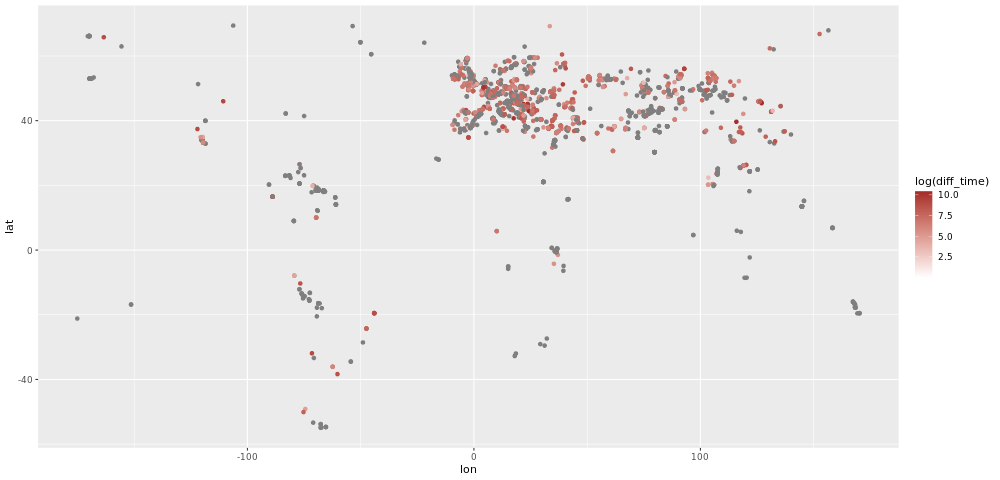

In [65]:
%%R -w 1000

read.table("../../sandbox/AADR/4/pred_1_0_100000000.txt", header = T) %>% 
    left_join(read.csv("../../files/AADR_filtered_metadata.txt", header = T, sep = "\t") %>% select(ind = indivi, lat = latitu, lon = longit), by = c("ind")) %>%
    mutate(lon = as.numeric(as.character(lon)),
           lat = as.numeric(as.character(lat))) %>%
    ggplot() +
    geom_jitter(aes(x = lon, y = lat, color = log(diff_time))) +
    scale_color_gradient2(low = "blue", 
                         mid = "white", 
                         high = "brown", 
                         midpoint = 0)

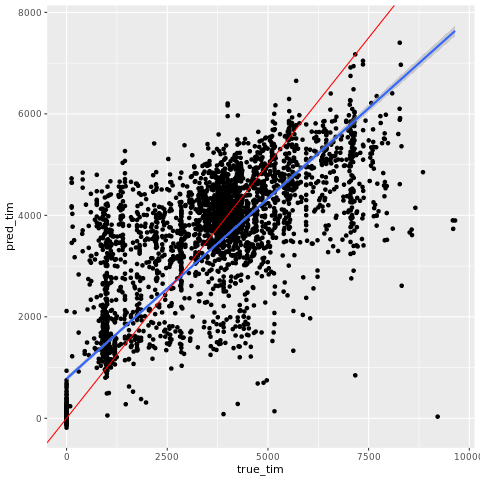

In [66]:
%%R

read.table("../../sandbox/AADR/14/pred_1_0_1000000000.txt", header = T) %>%
    ggplot() +
    geom_point(aes(x = true_tim, y = pred_tim)) +
    geom_smooth(method = "lm", formula = 'y ~ x', aes(x = true_tim, y = pred_tim))+
    geom_abline(intercept = 0, slope = 1, color = "red")

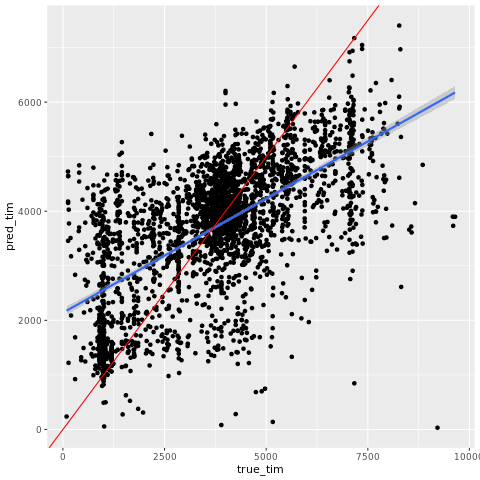

In [67]:
%%R

read.table("../../sandbox/AADR/14/pred_1_0_1000000000.txt", header = T) %>%
    filter(true_tim > 0) %>%
    ggplot() +
    geom_point(aes(x = true_tim, y = pred_tim)) +
    geom_smooth(method = "lm", formula = 'y ~ x', aes(x = true_tim, y = pred_tim))+
    geom_abline(intercept = 0, slope = 1, color = "red")